# 통합 EDA

#### 한글폰트

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 나눔 폰트 설정 ---
# 시스템에 '나눔고딕' 폰트가 설치되어 있는지 확인하고 설정합니다.

# 나눔고딕 폰트 파일 경로 찾기
nanum_font_path = None
for font_path in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    font_name = fm.FontProperties(fname=font_path).get_name()
    if "NanumGothic" in font_name or "NanumGothicCoding" in font_name: # 다양한 나눔고딕 계열 폰트 확인
        nanum_font_path = font_path
        print(f"나눔 폰트 '{font_name}'을(를) 찾았습니다: {nanum_font_path}")
        break

if nanum_font_path:
    # 폰트 프로퍼티 설정
    font_prop = fm.FontProperties(fname=nanum_font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지
    print("matplotlib 나눔 폰트 설정이 완료되었습니다.")
else:
    print("시스템에서 '나눔고딕' 폰트를 찾을 수 없습니다. 폰트를 설치하거나 다른 한글 폰트를 지정해주세요.")
    print("예: 다른 폰트로 설정하려면 'plt.rcParams['font.family'] = 'Malgun Gothic'' 와 같이 변경 가능합니다.")
    print("혹은 폰트 파일을 직접 다운로드하여 설치해야 할 수도 있습니다.")

# eda 계획 
- 전체 eda 진행 : 카테고리_검색량, 브랜드_검색량, 상품명_검색량
- 마켓컬리 eda 진행 : 리뷰 수와 전체 eda에서 제외된 변수들과의 상관관계 분석
- 이마트몰 eda 진행 : 마켓컬리 eda와 동일하게 진행

# 모든 eda는 동일한 프로세스로 진행
1. 범주형 변수 단변량 & 수치형 변수 단변량 eda
2. 이변량 eda
3. IQR로 이상치 탐지
4. 다변량 eda
5. 정규성 검증
6. 기술 통계

## 전체 eda 진행

## 데이터프레임 정보파악
- 범주형과 수치형을 나누기 위해 데이터 타입 변경 작업

In [ ]:
import pandas as pd
df = pd.read_csv('0716_머신러닝v6_정제 최종본.csv')
df.info()

In [ ]:
# URL_ID  string으로 변환
df['URL_ID'] = df['URL_ID'].astype(str)
# 긍정감성점수를 제외한 float64 컬럼들을 int로 변환
df['총용량'] = df['총용량'].astype(int)
df['입수량'] = df['입수량'].astype(int)
df['개당_가격'] = df['개당_가격'].astype(int)
df['10g당_가격'] = df['10g당_가격'].astype(int)
df['할인율'] = df['할인율'].astype(int)
df['정상가'] = df['정상가'].astype(int)
df['판매가'] = df['판매가'].astype(int)
df['카테고리_검색량'] = df['카테고리_검색량'].astype(int)
df['브랜드_검색량'] = df['브랜드_검색량'].astype(int)
df['상품명_검색량'] = df['상품명_검색량'].astype(int)
df['리뷰수'] = df['리뷰수'].astype(int)

df.info()

## 리뷰수가 0인데 긍정감성점수가 0이 아닌 행을 발견 ->  정제 필요

In [ ]:
# 리뷰수 0인데 긍정감성점가 0이 아닌 경우 0으로 대체
df.loc[(df['리뷰수'] == 0) & (df['긍정감성점수'] != 0), '긍정감성점수'] = 0

[범주형 변수]
- 사이트: 이마트몰, 마켓컬리
- 상품ID: 상품의 고유번호
- 브랜드
- 상품명: 웹크롤링에 기준이 되는 변수
- 포장타입: 냉동, 냉장, 상온
- 카테고리_대분류  

[연속형 변수]
- 용량: 용량에 입수량을 곱한 상품의 총용량
- 입수량: 개입
- 개당_가격 : 입수량 하나당 가격      
- 10g당_가격      
- 할인율: 할인율 없는 건 0, 30% -> 30         
- 정상가           
- 판매가 
- 리뷰: 리뷰수 
- 긍정감성점수: 리뷰 없는 것은 0, 리뷰있는건 부정0, 긍정1 -> 1의 비율 계산
- 카테고리_대분류 검색량, 브랜드_검색량, 상품명_검생량 : 각 범주형 변수에 검색량 따로 크롤링해서 가져온 변수

In [ ]:


import matplotlib.pyplot as plt

# Display summary statistics for numerical columns
print(df.describe().to_markdown(numalign="left", stralign="left"))

# Select numerical columns for histogram
numerical_cols = ['총용량', '입수량', '개당_가격', '10g당_가격', '할인율', '정상가', '판매가', '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수', '긍정감성점수']

# Create histograms for numerical columns
df[numerical_cols].hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.suptitle('Histograms of Numerical Columns', y=1.02)
plt.savefig('numerical_columns_histograms.png')


## 수치형 변수 단변량 eda
총용량 (Total Volume):

분포: 최소 10에서 최대 32,000까지 매우 넓은 범위를 가지며, 평균은 약 732입니다. 분포는 오른쪽으로 크게 치우쳐 있습니다.

인사이트: 소량의 간편식부터 대용량 제품까지 다양한 용량의 제품이 판매되고 있습니다. 극히 일부의 대용량 제품이 평균을 높이는 경향이 있습니다.

입수량 (Quantity per Pack):

분포: 대부분의 제품이 1개입이지만, 최대 300개입 제품도 존재합니다.

인사이트: 개별 포장 제품이 주를 이루지만, 일부 벌크형 또는 다량 포장 제품도 있음을 알 수 있습니다.

개당_가격 (Price Per Unit), 정상가 (Original Price), 판매가 (Selling Price):

분포: 가격대(개당 가격, 정상가, 판매가)는 최소 수십 원대에서 최대 수십만 원대까지 매우 넓은 범위를 가지며, 평균은 8,000원 ~ 12,000원대입니다. 히스토그램에서 보듯이 대부분의 가격이 낮은 구간에 집중되어 있고, 소수의 고가 제품이 분포를 오른쪽으로 길게 만듭니다.

인사이트: 대중적인 가격대의 제품이 많지만, 프리미엄 또는 특수 제품으로 보이는 고가 제품군도 존재합니다. 이들의 분포가 매우 치우쳐 있음을 볼 때, 가격 전략이 다양하게 구사되고 있음을 유추할 수 있습니다. 정상가와 판매가의 평균이 유사하고, 히스토그램 분포도 거의 동일하게 나타나는 것은 할인이 없는 제품이 많거나 할인율이 크지 않은 경우가 많다는 것을 보여줍니다.

10g당_가격 (Price per 10g):

분포: 최소 8.56에서 최대 2916.67까지 넓은 범위를 가지며, 평균은 227.5입니다.

인사이트: 제품의 단위 가격 밀도가 매우 다양합니다. 이는 제품의 원재료, 가공 방식, 브랜드 가치 등에 따라 단위당 가격이 크게 달라질 수 있음을 시사합니다.

할인율 (Discount Rate):

분포: 대부분의 제품이 0%의 할인율을 보이며, 최대 50%까지 할인이 적용된 제품도 있습니다.

인사이트: 상시 할인이 적용되지 않는 제품이 많으며, 특정 프로모션이나 기획전을 통해 일부 제품에 대해 높은 할인율이 적용될 수 있음을 보여줍니다.

카테고리_검색량 (Category Search Volume), 브랜드_검색량 (Brand Search Volume), 상품명_검색량 (Product Name Search Volume):

분포: 각 검색량 모두 최소 20에서 최대 수십만까지 넓은 범위를 가지며, 분포가 오른쪽으로 크게 치우쳐 있습니다.

인사이트: 특정 카테고리, 브랜드, 또는 상품명이 압도적으로 높은 검색량을 보입니다. 이는 소수의 인기 있는 카테고리/브랜드/제품이 시장의 주요 관심사를 형성하고 있음을 나타내며, 마케팅 및 제품 개발 시 이러한 트렌드를 파악하는 것이 중요함을 시사합니다.

리뷰수 (Number of Reviews):

분포: 대부분의 제품이 낮은 리뷰수를 가지지만, 최대 108,145개에 달하는 리뷰를 가진 제품도 존재합니다. 분포는 극도로 오른쪽으로 치우쳐 있습니다.

인사이트: 소수의 제품이 매우 높은 소비자 참여도와 인기를 얻고 있음을 분명히 보여줍니다. 리뷰 수가 많은 제품은 소비자들에게 신뢰를 얻고 구매 결정에 큰 영향을 미칠 가능성이 높습니다.

긍정감성점수 (Positive Sentiment Score):

분포: 0에서 1 사이의 값을 가지며, 평균은 0.67입니다.

인사이트: 전반적으로 제품에 대한 소비자들의 긍정적인 평가가 우세함을 나타냅니다. 하지만 0에 가까운 낮은 점수를 가진 제품도 있어, 일부 제품에서는 개선이 필요할 수 있음을 시사합니다.

--> 전체적으로 한쪽으로 몰려 있는 그래프이기 때문에 로그변환하여 다시 분석이 필요해보임.

## 수치형 변수 1차 상관관계 표
- 용량과 가격 간의 중간정도의 양의 상관관계 처럼 일반적으로 총용량이 큰 제품일수록 가격이 높아지는 경향이 있는 상관관계 제외하면 전체적으로 약한 상관관계를 지니고 잇음
-  로그변환 후 다시 확인 필요

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# CSV 파일을 데이터프레임으로 읽기 (데이터프레임 'df'가 이미 로드되어 있다고 가정)
# df = pd.read_csv('0714_브랜드_수정_마켓컬리_이마트몰_병합(최종 상품ID포함).csv')

# 히트맵 생성을 위한 수치형 열 선택
numerical_cols = ['총용량', '입수량', '개당_가격', '10g당_가격', '할인율', '정상가', '판매가', '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수', '긍정감성점수']

# 수치형 열에 대한 상관관계 행렬 계산
correlation_matrix = df[numerical_cols].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('수치형 변수 간 상관관계 히트맵', fontsize=16)

plt.show()

## 사이트별 총 리뷰수 분석
- 사이트별 총 리뷰수 막대그래프출력
- 마켓컬리가 이마트몰보다 훨씬 많은 총 리뷰수를 가지고 있습니다

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by '사이트' and sum '리뷰수'
site_reviews = df.groupby('사이트')['리뷰수'].sum().reset_index()

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='사이트', y='리뷰수', data=site_reviews, palette='viridis')
plt.title('사이트별 총 리뷰수')
plt.xlabel('사이트')

plt.ylabel('총 리뷰수')
plt.ticklabel_format(style='plain', axis='y') # To prevent scientific notation on y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('site_reviews_bar_chart.png')

## 브랜드별 리뷰수 분석
- 브랜드 상위 리뷰수 (평균 vs 중앙값)
    - 상위 10개만 추출해 분석한 결과 금미옥, 미미네, 멕시카나 순으로 리뷰수 가장 많음
    - 하지만 전체적으로 마켓컬리 리뷰 수가 우세하기 때문에 이 리뷰수는 마켓컬리 사이트의 리뷰수일 가능성 높음

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 브랜드별 평균 및 중앙값 리뷰 수 계산
브랜드_리뷰통계 = df.groupby('브랜드')['리뷰수'].agg(['mean', 'median'])

# 리뷰 수 평균 기준 상위 10개 브랜드 추출
상위10_브랜드 = 브랜드_리뷰통계.sort_values(by='mean', ascending=False).head(10)

# 컬럼명 한글로 변경 (시각화 가독성)
상위10_브랜드.columns = ['평균리뷰수', '중앙값리뷰수']

# 시각화
상위10_브랜드.plot(kind='bar', figsize=(10,6))
plt.title('브랜드별 평균 vs 중앙값 리뷰 수 (상위 10개 기준)')
plt.ylabel('리뷰 수')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 범주형 변수인 포장타입, 카테고리 막대그래프 추출
- 포장타입 (Packaging Type): 리뷰수랑 비교

    - 분포: '냉동' 제품이 746개로 가장 많고, '냉장' (226개), '상온' (214개) 순입니다.

    - 인사이트: 판매되는 간편식 제품 중 냉동 제품의 비중이 압도적으로 높습니다. 이는 보관 용이성, 유통기한 연장 등 냉동 포장의 이점이 간편식 시장에서 중요하게 작용함을 시사합니다.

- 카테고리 (Category): 리뷰수랑 비교

    - 분포: '간편조리식품' (306개), '분식' (256개), '즉석식품' (192개), '밀키트' (175개), '곡물간편식' (134개), '면류' (101개), '샐러드간편식' (22개) 순으로 분포합니다.

    - 인사이트: '간편조리식품'과 '분식'이 주요 카테고리임을 알 수 있습니다. 이는 소비자들이 간편하게 조리할 수 있는 식사 대용이나 스낵류에 대한 수요가 높음을 반영합니다. 반면 '샐러드간편식'은 아직 시장 규모가 작거나 데이터 수집 비중이 낮을 수 있습니다.

In [ ]:
# `포장타입` (Packaging Type) 막대그래프
plt.figure(figsize=(10, 7))
sns.countplot(x='포장타입', data=df, palette='viridis', order=df['포장타입'].value_counts().index)
plt.title('포장타입별 제품 수')
plt.xlabel('포장타입')
plt.ylabel('제품 수')
plt.savefig('packaging_type_product_count_bar_chart.png')
plt.show()

# `카테고리` (Category) 막대그래프
plt.figure(figsize=(12, 8))
sns.countplot(x='카테고리', data=df, palette='viridis', order=df['카테고리'].value_counts().index)
plt.title('카테고리별 제품 수')
plt.xlabel('카테고리')
plt.ylabel('제품 수')
plt.xticks(rotation=45, ha='right') # 라벨이 겹치지 않도록 회전
plt.tight_layout() # 그래프 요소들이 잘 보이도록 조정
plt.savefig('category_product_count_bar_chart.png')
plt.show()

## 평균 리뷰수와 포장타입, 카테고리 분석
- 리뷰수를 평균으로 정한 이유 : 해당 범주의 제품들이 일반적으로 얼마나 많은 리뷰를 받는지 직접적으로 비교할 수 있습니다
    - 포장타입별 평균 리뷰 수 비교 인사이트 (이마트몰 vs 마켓컬리)
    - 냉동 제품 리뷰 수 차이 두드러짐
마켓컬리: 냉동 제품 평균 리뷰 수가 약 4,900건으로 가장 높음
이마트몰: 냉동 제품은 약 1,000건 이하로 가장 낮음

 마켓컬리는 냉동 HMR 중심의 플랫폼으로 자리 잡고 있어, 냉동 간편식 수요가 활발
 반면 이마트몰은 냉동 제품에 대한 리뷰 확보가 부족, 구매 전환이나 만족도 측정에 어려움
 → 냉동 제품군 리뷰 유도 전략 필요

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the data if df is not already loaded (for robustness)
# df = pd.read_csv('0714_브랜드_수정_마켓컬리_이마트몰_병합(최종 상품ID포함).csv')

# --- 마켓컬리 EDA (로그 변환 전 값만) ---
df_marketkurly_orig = df[df['사이트'] == '마켓컬리'].copy()

print("### 마켓컬리 EDA: 리뷰수 (로그 변환 전)와 범주형 변수 간의 관계\n")

fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 row, 2 columns

# 마켓컬리 - 원본 리뷰수 by 포장타입
sns.barplot(x='포장타입', y='리뷰수', data=df_marketkurly_orig, estimator=np.mean, palette='viridis', ax=axes[0])
axes[0].set_title('마켓컬리: 포장타입별 평균 리뷰수')
axes[0].set_xlabel('포장타입')
axes[0].set_ylabel('평균 리뷰수')
axes[0].ticklabel_format(style='plain', axis='y') # Prevent scientific notation

# 마켓컬리 - 원본 리뷰수 by 카테고리
category_order_mk_orig = df_marketkurly_orig.groupby('카테고리')['리뷰수'].mean().sort_values(ascending=False).index
sns.barplot(x='카테고리', y='리뷰수', data=df_marketkurly_orig, estimator=np.mean, palette='viridis', ax=axes[1], order=category_order_mk_orig)
axes[1].set_title('마켓컬리: 카테고리별 평균 리뷰수')
axes[1].set_xlabel('카테고리')
axes[1].set_ylabel('평균 리뷰수')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('마켓컬리: 리뷰수 (로그 변환 전)와 범주형 변수 간의 관계', y=0.98, fontsize=16)
plt.savefig('marketkurly_reviews_original_barplot.png')
plt.show()

# --- 이마트몰 EDA (로그 변환 전 값만) ---
df_emart_orig = df[df['사이트'] == '이마트몰'].copy()

print("\n### 이마트몰 EDA: 리뷰수 (로그 변환 전)와 범주형 변수 간의 관계\n")

fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 row, 2 columns

# 이마트몰 - 원본 리뷰수 by 포장타입
sns.barplot(x='포장타입', y='리뷰수', data=df_emart_orig, estimator=np.mean, palette='viridis', ax=axes[0])
axes[0].set_title('이마트몰: 포장타입별 평균 리뷰수')
axes[0].set_xlabel('포장타입')
axes[0].set_ylabel('평균 리뷰수')
axes[0].ticklabel_format(style='plain', axis='y')

# 이마트몰 - 원본 리뷰수 by 카테고리
category_order_emart_orig = df_emart_orig.groupby('카테고리')['리뷰수'].mean().sort_values(ascending=False).index
sns.barplot(x='카테고리', y='리뷰수', data=df_emart_orig, estimator=np.mean, palette='viridis', ax=axes[1], order=category_order_emart_orig)
axes[1].set_title('이마트몰: 카테고리별 평균 리뷰수')
axes[1].set_xlabel('카테고리')
axes[1].set_ylabel('평균 리뷰수')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('이마트몰: 리뷰수 (로그 변환 전)와 범주형 변수 간의 관계', y=0.98, fontsize=16)
plt.savefig('emart_reviews_original_barplot.png')
plt.show()

# 카테고리별 평균 로그 변환된 카테고리_검색량


- 그래프를 보면, 밀키트 카테고리의 평균 로그 변환된 검색량이 다른 카테고리에 비해 압도적으로 높은 것을 확인할 수 있습니다.

- 그다음으로 간편조리식품과 즉석식품이 비교적 높은 평균 검색량을 보입니다.

- 분식, 곡물간편식, 면류, 샐러드간편식은 상대적으로 낮은 평균 검색량을 가집니다

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the data if df is not already loaded (for robustness)
# df = pd.read_csv('0714_브랜드_수정_마켓컬리_이마트몰_병합(최종 상품ID포함).csv')

# Create a log-transformed DataFrame for relevant numerical columns
# (re-creating for robustness, although it should exist from previous steps)
numerical_cols_to_log = ['카테고리_검색량'] # Only need 카테고리_검색량 for this plot

df_plot = df.copy()
for col in numerical_cols_to_log:
    df_plot[f'log_{col}'] = np.log1p(df_plot[col])

# Calculate the mean of log-transformed 카테고리_검색량 for each 카테고리
mean_category_search_volume_log = df_plot.groupby('카테고리')['log_카테고리_검색량'].mean().sort_values(ascending=False).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='카테고리', y='log_카테고리_검색량', data=mean_category_search_volume_log, palette='viridis')
plt.title('카테고리별 평균 로그 변환된 카테고리_검색량')
plt.xlabel('카테고리')
plt.ylabel('평균 로그(1+카테고리_검색량)')
plt.xticks(rotation=45, ha='right') # Corrected x-axis label rotation and alignment
plt.tight_layout()
plt.savefig('category_mean_log_search_volume_barplot.png')
plt.show()

## 이상치 탐지
-  카테고리_검색량, 브랜드_검색량, 상품명_검색량 컬럼에 대해 IQR 방식으로 이상치를 탐지한 결과,
카테고리_검색량을 제외한 나머지 이상치 탐지
- 하지만 이들을 제거할 경우, 상위 인기 상품에 대한 분석 정보가 손실
- 이상치를 제거하면 데이터 수가 급감하여 분석 신뢰도가 낮아짐
- 이상치를 제거하는 대신, np.log1p() 함수를 활용해 리뷰 수에 로그 변환을 적용
- **마켓컬리 머신러닝 모델을 만들 때 이상치 조절 가능성을 위해 남기기로 결정**

In [ ]:
import pandas as pd
import numpy as np

# EDA 대상 변수 정의
overall_eda_cols = ['카테고리_검색량', '브랜드_검색량', '상품명_검색량']

print("### 3. IQR로 이상치 탐지\n")

outlier_results = {}

for col in overall_eda_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / len(df)) * 100

    outlier_results[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': num_outliers,
        'Percentage of Outliers': percentage_outliers
    }
    print(f"**변수: {col}**")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  하한선 (Lower Bound): {lower_bound:.2f}")
    print(f"  상한선 (Upper Bound): {upper_bound:.2f}")
    print(f"  이상치 개수: {num_outliers} ({percentage_outliers:.2f}%)")

    # Optionally, show some outlier examples if there are not too many
    if num_outliers > 0 and num_outliers <= 10:
        print("  이상치 예시:")
        print(outliers[[col]].head(10).to_markdown(index=False, numalign="left", stralign="left"))
    elif num_outliers > 10:
        print("  이상치가 많으므로 상위 10개 예시만 표시:")
        print(outliers.sort_values(by=col, ascending=False)[[col]].head(10).to_markdown(index=False, numalign="left", stralign="left"))
    print("-" * 50)

print("\nIQR 기반 이상치 탐지 결과 요약:\n")
outlier_summary_df = pd.DataFrame(outlier_results).T
print(outlier_summary_df[['Number of Outliers', 'Percentage of Outliers']].to_markdown(numalign="left", stralign="left"))

## 수치형 변수 로그로 변환하여 다시 그래프 확인
- 히스토그램 : 
    - 더 정규 분포에 가깝게 변환되었음을 확인할 수 있습니다. 이는 데이터의 왜곡을 줄여 통계 모델링에 더 적합한 형태로 만들 수 있습니다.

- 히트맵: 
    - 가격 관련 변수 간의 강한 양의 상관관계: 이전과 마찬가지로 개당_가격, 정상가, 판매가는 여전히 매우 강한 양의 상관관계를 유지합니다. (거의 1에 가까운 값)

    - 총용량과 가격 간의 관계 변화: 총용량과 개당_가격, 정상가, 판매가 사이의 상관계수가 이전보다 다소 증가하여, 로그 변환 후 선형 관계가 더 잘 드러남을 시사합니다.

    - 검색량 및 리뷰 관련 변수의 관계 변화: 카테고리_검색량, 브랜드_검색량, 상품명_검색량, 리뷰수 등 이전에 약한 상관관계를 보였던 변수들 간의 관계가 로그 변환 후 약간 더 뚜렷해진 부분이 있을 수 있습니다. 예를 들어, 리뷰수와 상품명_검색량 간의 양의 상관관계가 더 명확하게 나타나는 것을 볼 수 있습니다. 긍정감성점수는 여전히 다른 변수들과 약한 상관관계를 보입니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns for transformation
numerical_cols = ['총용량', '입수량', '개당_가격', '10g당_가격', '할인율', '정상가', '판매가', '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수', '긍정감성점수']

# Create a copy of the DataFrame for log transformation
df_log = df[numerical_cols].copy()

# Apply log1p transformation to handle potential zero values
for col in numerical_cols:
    # Check if the column has non-positive values before applying log1p
    if (df_log[col] <= 0).any():
        print(f"Warning: Column '{col}' contains non-positive values. Using np.log1p for transformation.")
        df_log[col] = np.log1p(df_log[col])
    else:
        df_log[col] = np.log(df_log[col])


# Generate histograms for log-transformed numerical columns
df_log.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.suptitle('Histograms of Log-Transformed Numerical Columns', y=1.02)
plt.savefig('log_transformed_numerical_columns_histograms.png')
plt.show()

# Calculate the correlation matrix for log-transformed numerical columns
correlation_matrix_log = df_log.corr()

# Plot the heatmap for log-transformed data
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_log, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Log-Transformed Numerical Columns')
plt.savefig('log_transformed_correlation_matrix.png')
plt.show()

## 정규성을 띄는 지에 대한 검증
    - 먼저 QQ-plot으로 시각화 후 정확한 수치상 계산을 위해 shapiro 검정 진행(로그로 변환된 변수)
- 가격 및 용량 관련 변수 (총용량, 개당_가격, 정상가, 판매가, 10g당_가격): 로그 변환 후 직선에 매우 가깝게 나타나, 정규성 가정을 위한 좋은 변환이었음을 보여줍니다.

- 할인율 (할인율): 0% 할인이 많기 때문에 로그 변환 후에도 하단에 데이터가 몰려있는 경향이 있지만, 그 외의 값들은 비교적 직선을 따릅니다.

- 검색량 관련 변수 (카테고리_검색량, 브랜드_검색량, 상품명_검색량): 이 변수들도 로그 변환 후 상당히 정규성에 가까워졌습니다.

- 리뷰수 (리뷰수): 매우 심한 왜곡을 보였던 변수였으나, 로그 변환 후 직선에 근접하여 정규성이 크게 개선되었음을 확인할 수 있습니다.

- 긍정감성점수 (긍정감성점수): 이 변수는 0에서 1 사이의 값을 가지며, 로그 변환 후에도 끝단에서 약간의 이탈이 보일 수 있지만, 전반적으로는 정규 분포의 특성을 어느 정도 따르는 경향을 보입니다.

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd

# Assume df_log is already created from the previous step with log-transformed data
# If not, recreate it (as done in the previous step for robustness):
numerical_cols = ['총용량', '입수량', '개당_가격', '10g당_가격', '할인율', '정상가', '판매가', '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수', '긍정감성점수']
df_log = df[numerical_cols].copy()
for col in numerical_cols:
    df_log[col] = np.log1p(df_log[col]) # Using log1p consistently

# Create QQ plots for all log-transformed numerical columns, on a single page
fig, axes = plt.subplots(3, 4, figsize=(20, 15)) # 3 rows, 4 columns
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(numerical_cols):
    stats.probplot(df_log[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'QQ Plot of Log-Transformed {col}')
    axes[i].set_xlabel('이론적 분위수')
    axes[i].set_ylabel('표본 분위수')

plt.tight_layout()
plt.suptitle('QQ Plots of All Log-Transformed Numerical Columns', y=1.02)
plt.savefig('all_log_transformed_numerical_columns_qq_plots.png')
plt.show()

### shapiro검정
- 시각적 판단과 통계적 검정의 차이: QQ 플롯을 통해 로그 변환 후 분포가 정규 분포에 더 가까워졌다고 시각적으로 판단할 수 있었지만, 샤피로-윌크 검정 같은 통계적 검정은 매우 민감하여 대규모 데이터셋(여기서는 1186개 항목)에서는 작은 편차라도 정규성에서 벗어났다고 판단하는 경우가 많습니다.
- 귀무가설($H_0$)과 대립가설($H_1$) 설정:

    - 귀무가설 ($H_0$): 해당 데이터는 정규 분포를 따른다.
    - 대립가설 ($H_1$): 해당 데이터는 정규 분포를 따르지 않는다.
    **모든 변수에서 귀무가설($H_0$)을 기각한다는 것을 의미합니다. 즉, 통계적으로 유의미한 수준에서 **"해당 변수들이 정규 분포를 따른다고 볼 수 없다**
- 대안: 
    - 비모수적 방법으로 통계

In [ ]:
import scipy.stats as stats
import numpy as np
import pandas as pd

# 데이터프레임 'df'가 이미 로드되어 있다고 가정합니다.
# df = pd.read_csv('0714_브랜드_수정_마켓컬리_이마트몰_병합(최종 상품ID포함).csv')

# 로그 변환할 수치형 열 목록
numerical_cols = ['총용량', '입수량', '개당_가격', '10g당_가격', '할인율', '정상가', '판매가', '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수', '긍정감성점수']

# 로그 변환된 데이터를 담을 새로운 데이터프레임 생성 및 변환
df_log = df[numerical_cols].copy()
for col in numerical_cols:
    # 0 값을 처리하기 위해 np.log1p (log(1+x)) 사용
    df_log[col] = np.log1p(df_log[col])

print("로그 변환된 수치형 열에 대한 샤피로-윌크 검정 결과:")
print("-" * 70)

alpha = 0.05 # 유의 수준

for col in numerical_cols:
    stat, p = stats.shapiro(df_log[col])
    print(f'열: {col}')
    print(f'  검정 통계량 (W): {stat:.4f}')
    print(f'  P-값: {p:.4f}')
    if p > alpha:
        print(f'  결론: P-값 ({p:.4f}) > 알파 ({alpha})이므로 귀무가설을 기각하지 않습니다. (로그 변환된) 데이터는 정규 분포를 따르는 것으로 보입니다.')
    else:
        print(f'  결론: P-값 ({p:.4f}) <= 알파 ({alpha})이므로 귀무가설을 기각합니다. (로그 변환된) 데이터는 정규 분포를 따르지 않는 것으로 보입니다.')
    print("-" * 70)

# 비모수 검정 진행
- 예측해야하는 중요 변수인 '리뷰수'와 '브랜드_검색량','카테고리_검색량','상품명_검색량'과의 통계적 차이가 있는지에 대한 스피어만 검정 진행
    **결과**: 세 관계 모두 통계적으로 유의미하다

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Load the new dataset (if not already loaded in the environment)
# This block ensures df_log is available with log-transformed columns
if 'df_log' not in locals() or 'log_리뷰수' not in df_log.columns:
    df = pd.read_csv('0716_머신러닝v6_정제 최종본.csv')
    df_log = df.copy()

    skewed_numerical_cols = [
        '정상가', '판매가', '리뷰수', '브랜드_검색량',
        '상품명_검색량', '카테고리_검색량', '총용량', '입수량',
        '개당_가격', '10g당_가격'
    ]

    for col in skewed_numerical_cols:
        if col in df_log.columns:
            df_log[f'log_{col}'] = np.log1p(df_log[col])
        else:
            print(f"Warning: Column '{col}' not found for log transformation.")

print("Spearman Correlation between Search Volume and Review Count:\n")

# --- Correlation 1: log_상품명_검색량 and log_리뷰수 ---
print("1. log_상품명_검색량 vs log_리뷰수:")
if 'log_상품명_검색량' in df_log.columns and 'log_리뷰수' in df_log.columns:
    corr, p_value = spearmanr(df_log['log_상품명_검색량'], df_log['log_리뷰수'])
    print(f"  Spearman Correlation Coefficient: {corr:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Result: Statistically significant correlation (p < 0.05)")
    else:
        print(f"  Result: No statistically significant correlation (p >= 0.05)")
else:
    print("  Required columns not found for this comparison.")
print("-" * 60)

# --- Correlation 2: log_브랜드_검색량 and log_리뷰수 ---
print("2. log_브랜드_검색량 vs log_리뷰수:")
if 'log_브랜드_검색량' in df_log.columns and 'log_리뷰수' in df_log.columns:
    corr, p_value = spearmanr(df_log['log_브랜드_검색량'], df_log['log_리뷰수'])
    print(f"  Spearman Correlation Coefficient: {corr:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Result: Statistically significant correlation (p < 0.05)")
    else:
        print(f"  Result: No statistically significant correlation (p >= 0.05)")
else:
    print("  Required columns not found for this comparison.")
print("-" * 60)

# --- Correlation 3: log_카테고리_검색량 and log_리뷰수 ---
print("3. log_카테고리_검색량 vs log_리뷰수:")
if 'log_카테고리_검색량' in df_log.columns and 'log_리뷰수' in df_log.columns:
    corr, p_value = spearmanr(df_log['log_카테고리_검색량'], df_log['log_리뷰수'])
    print(f"  Spearman Correlation Coefficient: {corr:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Result: Statistically significant correlation (p < 0.05)")
    else:
        print(f"  Result: No statistically significant correlation (p >= 0.05)")
else:
    print("  Required columns not found for this comparison.")
print("-" * 60)

## 스피어만 상관계수표 히트맵
- 리뷰수와 각 검색량과의 관계성은 약해보이지만 그중 상품명 검색량은 유의미한 값을 나타낸다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Ensure df_log is available with log-transformed columns
# This block is re-included to make the code runnable independently if the kernel restarts
if 'df_log' not in locals() or 'log_리뷰수' not in df_log.columns:
    df = pd.read_csv('0716_머신러닝v6_정제 최종본.csv')
    df_log = df.copy()

    skewed_numerical_cols = [
        '정상가', '판매가', '리뷰수', '브랜드_검색량',
        '상품명_검색량', '카테고리_검색량', '총용량', '입수량',
        '개당_가격', '10g당_가격'
    ]

    for col in skewed_numerical_cols:
        if col in df_log.columns:
            df_log[f'log_{col}'] = np.log1p(df_log[col])
        else:
            print(f"Warning: Column '{col}' not found for log transformation.")

# Define the columns for the Spearman correlation heatmap
# Including all relevant numerical (and log-transformed) columns
heatmap_cols = [
    'log_리뷰수', 'log_상품명_검색량', 'log_브랜드_검색량', 'log_카테고리_검색량',
    'log_판매가', 'log_정상가', 'log_총용량', 'log_입수량',
    'log_개당_가격', 'log_10g당_가격', '긍정감성점수', '할인율', 'URL_ID'
]

# Filter df_log to only include the columns for the heatmap
df_heatmap = df_log[heatmap_cols].copy()

# Calculate the Spearman correlation matrix
spearman_corr_matrix = df_heatmap.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(
    spearman_corr_matrix,
    annot=True,        # Show the correlation values on the heatmap
    cmap='coolwarm',   # Color map
    fmt=".2f",         # Format annotation values to two decimal places
    linewidths=.5,     # Width of lines separating cells
    cbar_kws={'label': 'Spearman Correlation Coefficient'} # Color bar label
)

plt.title('Spearman 상관계수 히트맵', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('spearman_correlation_heatmap.png')
plt.show()

- 이마트몰은 간편식 시장에서 상대적으로 약세를 보이고 있음. 이에 따라 간편식에 강점을 가진 마켓컬리를 벤치마크 플랫폼으로 선정하고, 두 플랫폼의 공통 간편식 상품을 기준으로 차이를 비교·분석하고자 함.

# 이마트몰 vs 마켓컬리 간편식 비교 EDA

# 데이터 프레임 불러오기

In [1]:
import pandas as pd

df = pd.read_csv('0716_머신러닝v6_정제 최종본.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   상품ID      1186 non-null   object 
 1   사이트       1186 non-null   object 
 2   URL_ID    1186 non-null   int64  
 3   브랜드       1186 non-null   object 
 4   상품명       1186 non-null   object 
 5   포장타입      1186 non-null   object 
 6   개당_가격     1186 non-null   int64  
 7   10g당_가격   1186 non-null   int64  
 8   총용량       1186 non-null   int64  
 9   입수량       1186 non-null   int64  
 10  할인율       1186 non-null   int64  
 11  정상가       1186 non-null   int64  
 12  판매가       1186 non-null   int64  
 13  카테고리      1186 non-null   object 
 14  카테고리_검색량  1186 non-null   int64  
 15  브랜드_검색량   1186 non-null   int64  
 16  상품명_검색량   1186 non-null   int64  
 17  리뷰수       1186 non-null   int64  
 18  긍정감성점수    1186 non-null   float64
dtypes: float64(1), int64(12), object(6)
memory usage: 176.2+ KB


In [3]:
pd.set_option('display.max_rows', 10)

In [4]:
df.head()

,상품ID,사이트,URL_ID,브랜드,상품명,포장타입,개당_가격,10g당_가격,총용량,입수량,할인율,정상가,판매가,카테고리,카테고리_검색량,브랜드_검색량,상품명_검색량,리뷰수,긍정감성점수
0,product_311,마켓컬리,1001381558,정지선의 티엔미미,흑초가지,냉동,10965,313,350,1,15,12900,10965,밀키트,59300,30920,20,17,0.956522
1,product_413,마켓컬리,1001382104,포스트,통보리 그래놀라,상온,9980,199,500,1,0,9980,9980,곡물간편식,3560,7520,120,0,0.000000
2,product_414,마켓컬리,1001382102,포스트,현미 그래놀라,상온,9980,199,500,1,0,9980,9980,곡물간편식,3560,7520,360,0,0.000000
3,product_302,마켓컬리,1001390143,우양,어니언 뿌리즐 핫도그,냉동,1891,189,400,4,15,8900,7565,간편조리식품,1320,14780,20,1,0.666667
4,product_225,마켓컬리,1001390131,쉐프스토리,바삭한 핫도그,냉동,1260,157,400,5,10,7000,6300,간편조리식품,1320,1110,30,0,0.000000


## 분석 전 데이터 타입 바꾸기

In [5]:
# 총용량, 입수량, 개당_가격,  10g당_가격 정수로 변경
df['개당_가격'] = df['개당_가격'].astype(int)
df['10g당_가격'] = df['10g당_가격'].astype(int)
df['총용량'] = df['총용량'].astype(int)
df['입수량'] = df['입수량'].astype(int)

In [6]:
# URL_ID를 범주형으로 변경
df['URL_ID'] = df['URL_ID'].astype(object)

In [7]:
# 사이트에 따라 URL_ID 자릿수 맞춰 변환
def format_url_id(row):
    if row['사이트'] == '마켓컬리':
        return str(row['URL_ID']).zfill(10)
    elif row['사이트'] == '이마트몰':
        return str(row['URL_ID']).zfill(13)

# 적용
df['URL_ID'] = df.apply(format_url_id, axis=1)

# 범주형으로 변환
df['URL_ID'] = df['URL_ID'].astype(object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   상품ID      1186 non-null   object 
 1   사이트       1186 non-null   object 
 2   URL_ID    1186 non-null   object 
 3   브랜드       1186 non-null   object 
 4   상품명       1186 non-null   object 
 5   포장타입      1186 non-null   object 
 6   개당_가격     1186 non-null   int64  
 7   10g당_가격   1186 non-null   int64  
 8   총용량       1186 non-null   int64  
 9   입수량       1186 non-null   int64  
 10  할인율       1186 non-null   int64  
 11  정상가       1186 non-null   int64  
 12  판매가       1186 non-null   int64  
 13  카테고리      1186 non-null   object 
 14  카테고리_검색량  1186 non-null   int64  
 15  브랜드_검색량   1186 non-null   int64  
 16  상품명_검색량   1186 non-null   int64  
 17  리뷰수       1186 non-null   int64  
 18  긍정감성점수    1186 non-null   float64
dtypes: float64(1), int64(11), object(7)
memory usage: 176.2+ KB


In [9]:
df

,상품ID,사이트,URL_ID,브랜드,상품명,포장타입,개당_가격,10g당_가격,총용량,입수량,할인율,정상가,판매가,카테고리,카테고리_검색량,브랜드_검색량,상품명_검색량,리뷰수,긍정감성점수
0,product_311,마켓컬리,1001381558,정지선의 티엔미미,흑초가지,냉동,10965,313,350,1,15,12900,10965,밀키트,59300,30920,20,17,0.956522
1,product_413,마켓컬리,1001382104,포스트,통보리 그래놀라,상온,9980,199,500,1,0,9980,9980,곡물간편식,3560,7520,120,0,0.000000
2,product_414,마켓컬리,1001382102,포스트,현미 그래놀라,상온,9980,199,500,1,0,9980,9980,곡물간편식,3560,7520,360,0,0.000000
3,product_302,마켓컬리,1001390143,우양,어니언 뿌리즐 핫도그,냉동,1891,189,400,4,15,8900,7565,간편조리식품,1320,14780,20,1,0.666667
4,product_225,마켓컬리,1001390131,쉐프스토리,바삭한 핫도그,냉동,1260,157,400,5,10,7000,6300,간편조리식품,1320,1110,30,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,product_297,이마트몰,1000703705575,올반,새우볶음밥,냉동,3896,177,660,3,0,11690,11690,즉석식품,41710,1720,200,0,0.000000
1182,product_453,이마트몰,1000704047750,풀무원,새콤달콤 생쫄면,냉장,13740,298,460,1,0,13740,13740,면류,20,117300,90,0,0.000000
1183,product_165,이마트몰,1000705899833,본죽,본 통닭다리 백숙죽,냉장,10200,170,1200,2,0,20400,20400,밀키트,59300,472200,20,0,0.000000
1184,product_580,이마트몰,2097001728789,헤이밀,비건 만두,냉동,5600,133,420,1,0,5600,5600,간편조리식품,1320,540,40,216,0.889401


## 데이터 프레임 변수 설명

[범주형 변수]
- 사이트: 마켓컬리, 이마트몰 
- URL_ID: 각 사이트 상품의 고유번호 
- 브랜드: 상품명을 기준으로 동일하게 가져옴 
- 상품명: 마켓컬리, 이마트몰 공통상품임
- 포장타입: 냉동, 냉장, 상온 값 -> 상품명을 기준으로 동일하게 가져옴
- 카테고리: 상품명을 기준으로 동일하게 가져옴
- 상품ID: 동일한 상품명을 기준으로 새로 생성한 변수 (같은 상품이면 사이트가 달라도 같음)

[연속형 변수]
- 총용량: 용량에 입수량을 곱한 상품의 총용량
- 입수량: 개입
- 개당_가격 : 입수량 하나당 가격      
- 10g당_가격      
- 할인율: 할인율 없는 건 0, 30% -> 30         
- 정상가           
- 판매가 
- 리뷰수
- 긍정감성점수: 리뷰 없는 것은 0/ 리뷰있는건 부정0, 긍정1 -> 1의 비율 계산
- 카테고리 검색량, 브랜드_검색량, 상품명_검색량 : 각 범주형 변수에 검색량 따로 크롤링해서 가져온 변수

# 이마트몰 vs 마켓컬리 간편식 비교 EDA 준비

In [10]:
# EDA 진행을 위해 사이트 마켓컬리와 이마트몰 분리
df_마켓컬리 = df[df['사이트'] == '마켓컬리']
df_이마트몰 = df[df['사이트'] == '이마트몰']

- 상품ID: 이마트몰과 마켓컬리가 같은 상품인 걸 확인할 수 있는 변수

[이마트몰과 마켓컬리 값이 달라 비교분석 할 변수]
- 총용량: 용량에 입수량을 곱한 상품의 총용량
- 입수량: 개입
- 개당_가격 : 입수량 하나당 가격      
- 10g당_가격      
- 할인율: 할인율 없는 건 0, 30% -> 30         
- 정상가           
- 판매가 
- 리뷰수
- 긍정감성점수: 리뷰 없는 것은 0/ 리뷰있는건 부정0, 긍정1 -> 1의 비율 계산

# 기술통계 비교 분석

In [11]:
df_이마트몰.describe()

,개당_가격,10g당_가격,총용량,입수량,할인율,정상가,판매가,카테고리_검색량,브랜드_검색량,상품명_검색량,리뷰수,긍정감성점수
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,9024.086003,247.150084,782.025295,2.580101,0.349073,15434.851602,15334.091062,16380.202361,41254.957841,199.359191,1541.145025,0.474748
std,5495.467704,200.727771,764.728415,4.263382,3.012009,19676.858165,19535.995657,23201.220494,63533.564736,597.118300,5874.122787,0.460230
min,440.000000,29.000000,10.000000,1.000000,0.000000,1190.000000,1190.000000,20.000000,20.000000,20.000000,0.000000,0.000000
25%,5450.000000,149.000000,360.000000,1.000000,0.000000,7900.000000,7630.000000,20.000000,3040.000000,20.000000,0.000000,0.000000
50%,8420.000000,207.000000,505.000000,1.000000,0.000000,10900.000000,10900.000000,1320.000000,11370.000000,20.000000,2.000000,0.692308
75%,11480.000000,280.000000,943.000000,2.000000,0.000000,18888.000000,18888.000000,41710.000000,69500.000000,90.000000,228.000000,0.931667
max,42090.000000,2200.000000,7560.000000,36.000000,50.000000,415650.000000,415650.000000,59300.000000,472200.000000,7410.000000,60724.000000,1.000000


- 개당_가격: 평균 9,024원, 중앙값 8,420원, 표준편차 5,495원, 최소 440원 ~ 최대 42,090원
→ 일부 고가 제품으로 인해 오른쪽으로 치우친 분포 (우측 왜도)

- 10g당_가격: 평균 247원, 중앙값 200원, 표준편차 201원, 최소 29원 ~ 최대 2,200원
→ 프리미엄 제품 일부 존재, 분포 폭 넓음

- 총용량: 평균 782g, 중앙값 505g, 표준편차 764g, 최소 10g ~ 최대 7,560g
→ 대용량 극단값 존재, 평균과 표준편차에 영향

- 입수량: 평균 2.58개, 중앙값 1개, 표준편차 4.26개, 최소 1개 ~ 최대 36개
→ 단품 구성이 중심, 고입수 소수 포함

- 할인율: 평균 0.35%, 중앙값 0%, 표준편차 3.01%, 최소 0% ~ 최대 50%
→ 할인 거의 없음, 일부 높은 할인 제품 존재

- 정상가: 평균 15,434원, 중앙값 10,900원, 표준편차 19,676원, 최소 1,190원 ~ 최대 415,650원
→ 고가 제품으로 인해 평균과 분산 증가

- 판매가: 평균 15,334원, 중앙값 10,900원, 표준편차 15,935원, 최소 1,190원 ~ 최대 415,650원
→ 할인 반영 미미, 정상가와 유사한 분포

- 리뷰수: 평균 1,541개, 중앙값 2개, 표준편차 5,874개, 최소 0 ~ 최대 60,724개
→ 리뷰 없는 상품 다수, 인기 제품 일부 집중됨

- 긍정감성점수: 평균 0.47, 중앙값 0.69, 표준편차 0.46, 최소 0.0 ~ 최대 1.0
→ 리뷰 없는 상품은 0, 있는 경우는 대체로 긍정적

- 리뷰수: 평균 1,541개 중앙값 0개, 표준편차 5,874개 최소 0 ~ 최대 60,724개
→ 리뷰 없는 상품이 다수, 극단적인 인기 제품 존재

- 긍정감성점수: 평균 0.47 중앙값 0.69, 표준편차 0.46 최소 0.0 ~ 최대 1.0
→ 리뷰가 있는 상품은 대체로 긍정적, 없는 경우는 0으로 처리됨

In [12]:
df_마켓컬리.describe()

,개당_가격,10g당_가격,총용량,입수량,할인율,정상가,판매가,카테고리_검색량,브랜드_검색량,상품명_검색량,리뷰수,긍정감성점수
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,7138.087690,208.286678,618.908938,2.332209,6.768971,10085.126476,9435.591906,16280.236088,41254.957841,199.359191,4291.935919,0.866035
std,4074.685402,165.551287,814.946978,4.451229,8.425283,5521.260630,5441.307224,23143.618420,63533.564736,597.118300,11161.808822,0.143585
min,36.000000,46.000000,12.000000,1.000000,0.000000,1700.000000,1700.000000,20.000000,20.000000,20.000000,0.000000,0.000000
25%,4193.000000,133.000000,340.000000,1.000000,0.000000,7000.000000,6480.000000,20.000000,3040.000000,20.000000,115.000000,0.854962
50%,6980.000000,178.000000,450.000000,1.000000,0.000000,9300.000000,8500.000000,1320.000000,11370.000000,20.000000,713.000000,0.898305
75%,9900.000000,238.000000,645.000000,2.000000,12.000000,10980.000000,10710.000000,41710.000000,69500.000000,90.000000,3278.000000,0.926667
max,29800.000000,2916.000000,7560.000000,36.000000,50.000000,47900.000000,47900.000000,59300.000000,472200.000000,7410.000000,108145.000000,1.000000


- 개당_가격: 평균 7,138원, 중앙값 6,980원, 표준편차 4,075원, 최소 36원 ~ 최대 29,800원
→ 일부 고가 제품 존재, 평균이 소폭 더 높아 오른쪽으로 치우친 분포 (우측 왜도)

- 10g당_가격: 평균 208원, 중앙값 178원, 표준편차 166원, 최소 46원 ~ 최대 2,916원
→ 프리미엄 제품 일부 존재, 분포 폭 넓음

- 총용량: 평균 619g, 중앙값 450g, 표준편차 815g, 최소 12g ~ 최대 7,560g
→ 대용량 극단값 존재, 평균과 표준편차에 영향

- 입수량: 평균 2.33개, 중앙값 1개, 표준편차 4.45개, 최소 1개 ~ 최대 36개
→ 단품 구성이 중심, 고입수 소수 포함

- 할인율: 평균 6.77%, 중앙값 0%, 표준편차 8.43%, 최소 0% ~ 최대 50%
→ 할인 적용된 상품이 많고, 일부 높은 할인 제품 존재

- 정상가: 평균 10,085원, 중앙값 9,300원, 표준편차 5,521원, 최소 1,700원 ~ 최대 47,900원
→ 고가 제품 존재, 평균과 분산 증가

- 판매가: 평균 9,436원, 중앙값 8,500원, 표준편차 5,441원, 최소 1,700원 ~ 최대 47,900원
→ 할인 반영으로 가격 낮아졌지만, 전체적으로는 정상가와 유사한 분포

- 리뷰수: 평균 4,291개, 중앙값 713개, 표준편차 11,162개, 최소 0 ~ 최대 108,145개
→ 리뷰 많은 상품 다수, 인기 제품 일부 집중됨

- 긍정감성점수: 평균 0.87, 중앙값 0.89, 표준편차 0.14, 최소 0.0 ~ 최대 1.0
→ 리뷰 있는 상품은 대체로 긍정적, 없는 경우는 0으로 처리됨

## 비교 분석 정리

[개당_가격]
이마트몰: 평균 9,024원, 중앙값 8,420원, 표준편차 5,495원, 최대 42,090원
마켓컬리: 평균 7,138원, 중앙값 6,980원, 표준편차 4,075원, 최대 29,800원
→ 이마트몰이 가격대가 전반적으로 높고, 고가 제품 비중도 큼 (우측 왜도)

[10g당_가격]
이마트몰: 평균 247원, 중앙값 200원, 표준편차 201원
마켓컬리: 평균 208원, 중앙값 178원, 표준편차 166원
→ 마켓컬리가 단위당 가격이 더 낮고, 전체 가격 분포가 더 밀집됨

[총용량]
이마트몰: 평균 782g, 중앙값 505g, 표준편차 764g
마켓컬리: 평균 619g, 중앙값 450g, 표준편차 815g
→ 이마트몰은 대용량 제품이 더 많고, 평균과 분산이 모두 큼

[입수량]
이마트몰: 평균 2.58개, 중앙값 1개, 표준편차 4.26개
마켓컬리: 평균 2.33개, 중앙값 1개, 표준편차 4.45개
→ 두 플랫폼 모두 단품 구성 중심, 입수량 분포는 유사

[할인율]
이마트몰: 평균 0.35%, 중앙값 0%, 표준편차 3.01%
마켓컬리: 평균 6.77%, 중앙값 0%, 표준편차 8.43%
→ 마켓컬리는 할인 적용된 상품이 많고 할인폭도 큼, 이마트몰은 대부분 정가 판매

[정상가]
이마트몰: 평균 15,434원, 중앙값 10,900원, 표준편차 19,676원
마켓컬리: 평균 10,085원, 중앙값 9,300원, 표준편차 5,521원
→ 이마트몰은 고가 제품 영향으로 가격대와 분산이 모두 큼

[판매가]
이마트몰: 평균 15,334원, 중앙값 10,900원, 표준편차 15,935원
마켓컬리: 평균 9,436원, 중앙값 8,500원, 표준편차 5,441원
→ 마켓컬리가 전반적으로 실구매 가격이 더 낮고, 가격 안정성도 높음

[리뷰수]
이마트몰: 평균 1,541개, 중앙값 2개, 표준편차 5,874개
마켓컬리: 평균 4,291개, 중앙값 713개, 표준편차 11,162개
→ 마켓컬리는 리뷰 수가 많고 분포가 전반적으로 높음, 이마트몰은 리뷰 없는 상품이 다수

[긍정감성점수]
이마트몰: 평균 0.47, 중앙값 0.69, 표준편차 0.46
마켓컬리: 평균 0.87, 중앙값 0.89, 표준편차 0.14
→ 마켓컬리는 긍정 비율이 높은 상품이 많고, 분포도 안정적

[종합 관찰 요약]
- 가격대: 이마트몰은 고가 제품 비중 높고 분산 큼, 마켓컬리는 평균과 가격 안정성에서 유리
- 할인 전략: 마켓컬리는 다양한 할인 적용, 이마트몰은 할인 비활성
- 상품 구성: 두 플랫폼 모두 단품과 중소용량 중심이지만, 이마트몰은 평균 용량과 입수량이 소폭 높음
- 리뷰 수와 감성: 마켓컬리는 리뷰 수가 많고 긍정 비율도 높음, 이마트몰은 리뷰 유무 편차 큼

- 분석 결과, 마켓컬리는 중저가 + 할인 중심의 가격 전략, 소용량·단품 위주의 상품 구성, 그리고 리뷰 수 및 긍정 평가 비율이 높은 사용자 반응 구조를 보이는 등 여러 측면에서 이마트몰과 뚜렷한 차이를 나타냈다.
- 특히, 세 변수 중 리뷰 수는 고객 반응과 전환에 직접적인 영향을 줄 수 있는 핵심 지표로 판단되며,
이에 따라 어떤 요인이 리뷰 수에 영향을 주는지를 후속 분석을 통해 검증하고자 한다

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 범주형 변수 vs 리뷰수 이변량 분석

## 사이트

C:\Users\ssuyeon2\AppData\Local\Temp\ipykernel_16132\3140208105.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x='플랫폼', y='리뷰수', palette=custom_colors)


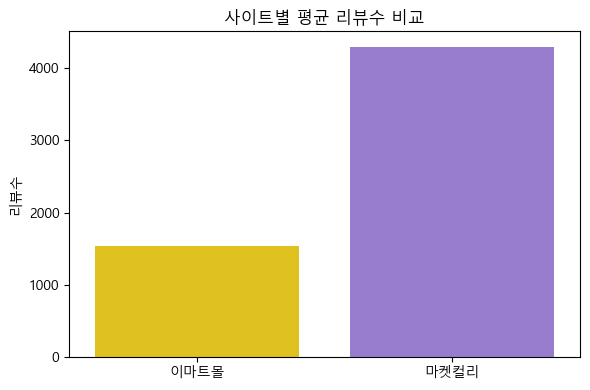

C:\Users\ssuyeon2\AppData\Local\Temp\ipykernel_16132\3140208105.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=median_df, x='플랫폼', y='리뷰수', palette=custom_colors)


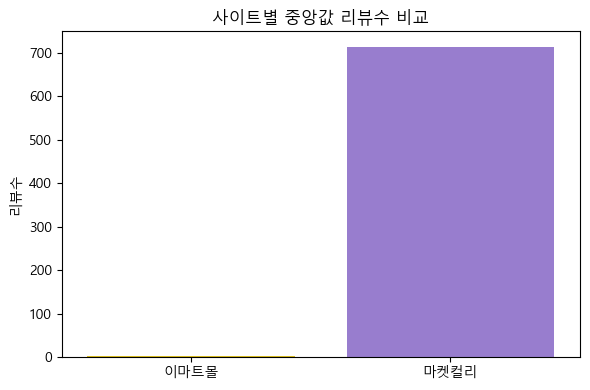

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 평균 & 중앙값 계산
mean_df = pd.DataFrame({
    '플랫폼': ['이마트몰', '마켓컬리'],
    '리뷰수': [
        df_이마트몰['리뷰수'].mean(),
        df_마켓컬리['리뷰수'].mean()
    ]
})

median_df = pd.DataFrame({
    '플랫폼': ['이마트몰', '마켓컬리'],
    '리뷰수': [
        df_이마트몰['리뷰수'].median(),
        df_마켓컬리['리뷰수'].median()
    ]
})

# 색상 지정
custom_colors = ['#FFD700', '#9370DB']  # 노란색(골드), 보라색(미디엄 퍼플)

# 시각화: 평균 리뷰수
plt.figure(figsize=(6, 4))
sns.barplot(data=mean_df, x='플랫폼', y='리뷰수', palette=custom_colors)
plt.title('사이트별 평균 리뷰수 비교')
plt.xlabel('')
plt.tight_layout()
plt.show()

# 시각화: 중앙값 리뷰수
plt.figure(figsize=(6, 4))
sns.barplot(data=median_df, x='플랫폼', y='리뷰수', palette=custom_colors)
plt.title('사이트별 중앙값 리뷰수 비교')
plt.xlabel('')
plt.tight_layout()
plt.show()


- 평균과 중앙값 모두에서 큰 차이를 보임 -> 전반적으로 마켓컬리의 리뷰 수가 이마트몰보다 압도적으로 많음

## 브랜드

In [16]:
# 브랜드의 고유 개수(유니크 브랜드 수) 확인
df['브랜드'].nunique()

149

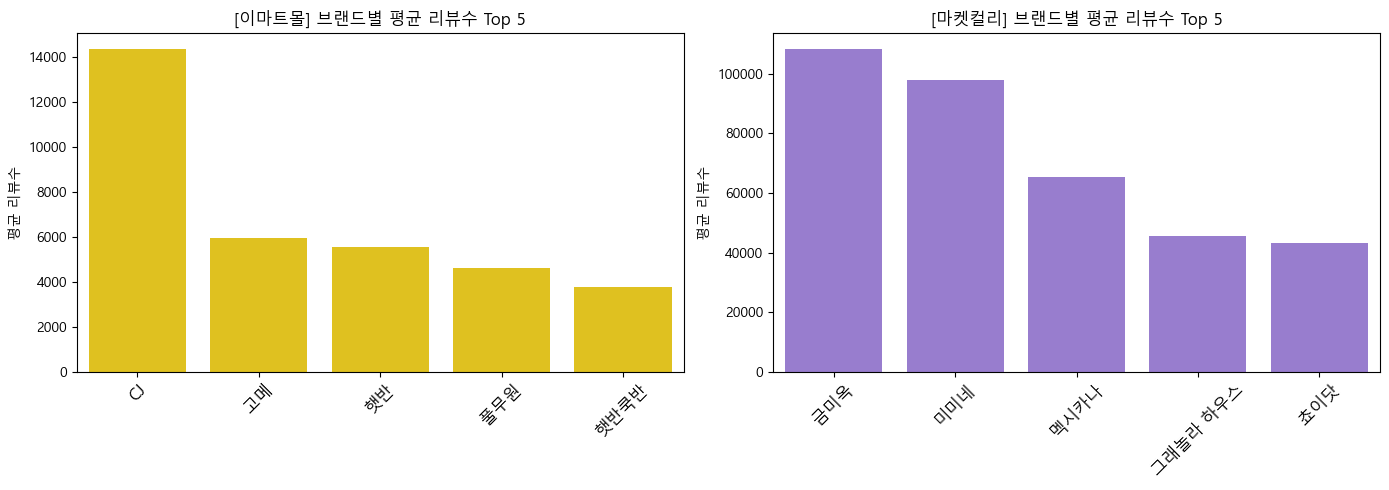

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 마켓컬리 Top 5 브랜드
top5_kurly = df_마켓컬리.groupby('브랜드')['리뷰수'].mean().sort_values(ascending=False).head(5)

# 이마트몰 Top 5 브랜드
top5_emart = df_이마트몰.groupby('브랜드')['리뷰수'].mean().sort_values(ascending=False).head(5)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 이마트몰 - 노란색
sns.barplot(x=top5_emart.index, y=top5_emart.values, ax=axes[0], color='#FFD700')
axes[0].set_title('[이마트몰] 브랜드별 평균 리뷰수 Top 5')
axes[0].set_xlabel('')  # 하단 '브랜드' 글자 제거
axes[0].tick_params(axis='x', rotation=45, labelsize=12)  # 브랜드 이름 글자 키움
axes[0].set_ylabel('평균 리뷰수')

# 마켓컬리 - 보라색
sns.barplot(x=top5_kurly.index, y=top5_kurly.values, ax=axes[1], color='#9370DB')
axes[1].set_title('[마켓컬리] 브랜드별 평균 리뷰수 Top 5')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].set_ylabel('평균 리뷰수')

plt.tight_layout()
plt.show()


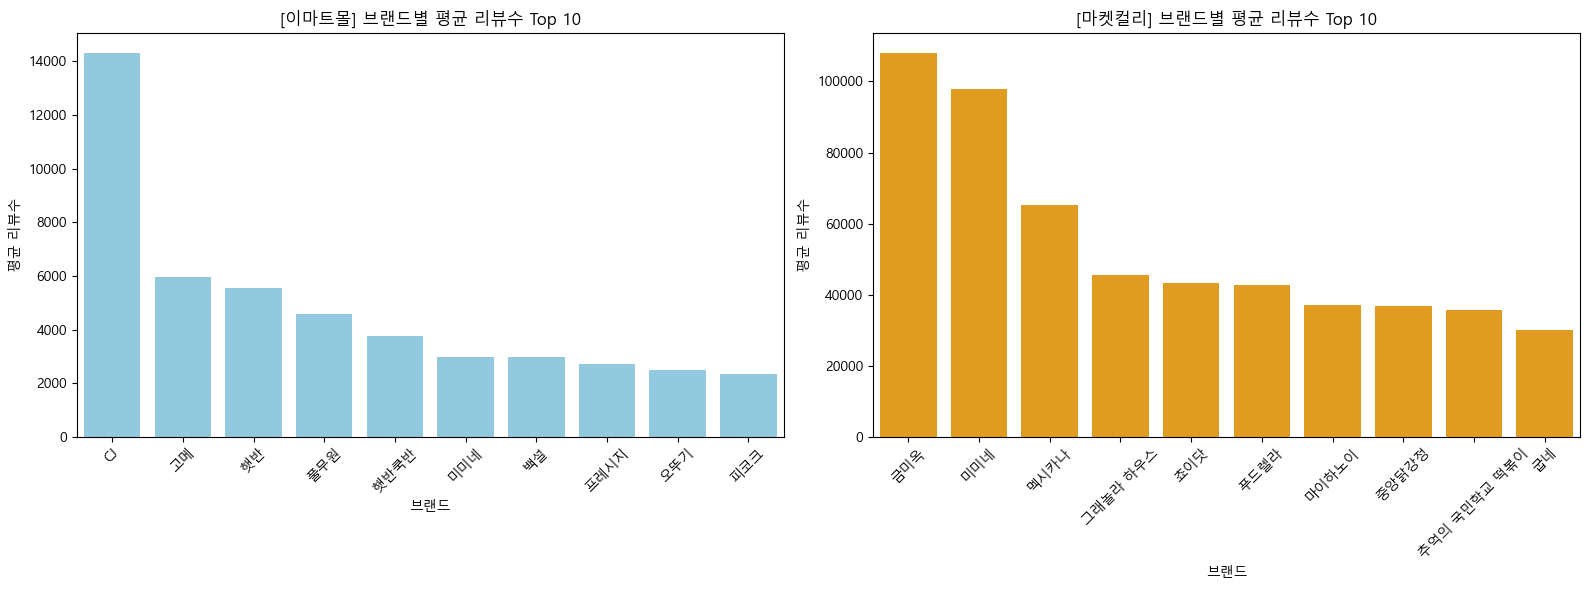

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 마켓컬리 Top 10 브랜드
top10_kurly = df_마켓컬리.groupby('브랜드')['리뷰수'].mean().sort_values(ascending=False).head(10)

# 이마트몰 Top 10 브랜드
top10_emart = df_이마트몰.groupby('브랜드')['리뷰수'].mean().sort_values(ascending=False).head(10)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=top10_emart.index, y=top10_emart.values, ax=axes[0], color='skyblue')
axes[0].set_title('[이마트몰] 브랜드별 평균 리뷰수 Top 10')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylabel('평균 리뷰수')

sns.barplot(x=top10_kurly.index, y=top10_kurly.values, ax=axes[1], color='orange')
axes[1].set_title('[마켓컬리] 브랜드별 평균 리뷰수 Top 10')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel('평균 리뷰수')

plt.tight_layout()
plt.show()


C:\Users\ssuyeon2\AppData\Local\Temp\ipykernel_16132\1691251128.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=brand_compare_melt, x='플랫폼', y='평균리뷰수', palette=['skyblue', 'orange'])


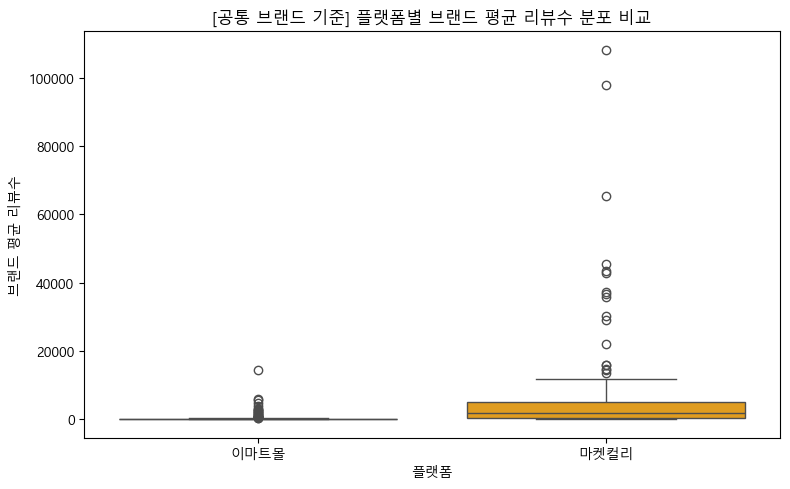

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 브랜드 평균 리뷰수 집계
mean_emart = df_이마트몰.groupby('브랜드')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '이마트몰'})
mean_kurly = df_마켓컬리.groupby('브랜드')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '마켓컬리'})

# 병합 (공통 브랜드만 추출됨)
brand_compare = pd.merge(mean_emart, mean_kurly, on='브랜드')

# melt for 시각화
brand_compare_melt = brand_compare.melt(id_vars='브랜드', value_vars=['이마트몰', '마켓컬리'],
                                        var_name='플랫폼', value_name='평균리뷰수')

# 박스플롯 (분포 비교)
plt.figure(figsize=(8, 5))
sns.boxplot(data=brand_compare_melt, x='플랫폼', y='평균리뷰수', palette=['skyblue', 'orange'])
plt.title('[공통 브랜드 기준] 플랫폼별 브랜드 평균 리뷰수 분포 비교')
plt.ylabel('브랜드 평균 리뷰수')
plt.tight_layout()
plt.show()


- 이마트몰은 CJ, 풀무원 등 대형 브랜드 중심으로 리뷰수가 높게 나타났고, 반면 마켓컬리는 금미옥, 미미네 등 중소형 브랜드도 평균 리뷰수가 높아 상위권에 포함되는 양상이 확인되었다.
- 또한 공통 브랜드 기준으로도 대부분 마켓컬리 쪽 리뷰수가 압도적으로 높았으며, 이는 마켓컬리가 브랜드 규모에 관계없이 리뷰 활성화 전략 및 사용자 후기를 잘 확보하고 있다는 점을 보여준다

→ 이마트몰도 중소 브랜드 리뷰 활성화를 위한 리뷰 유도 전략이 필요

## 상품명

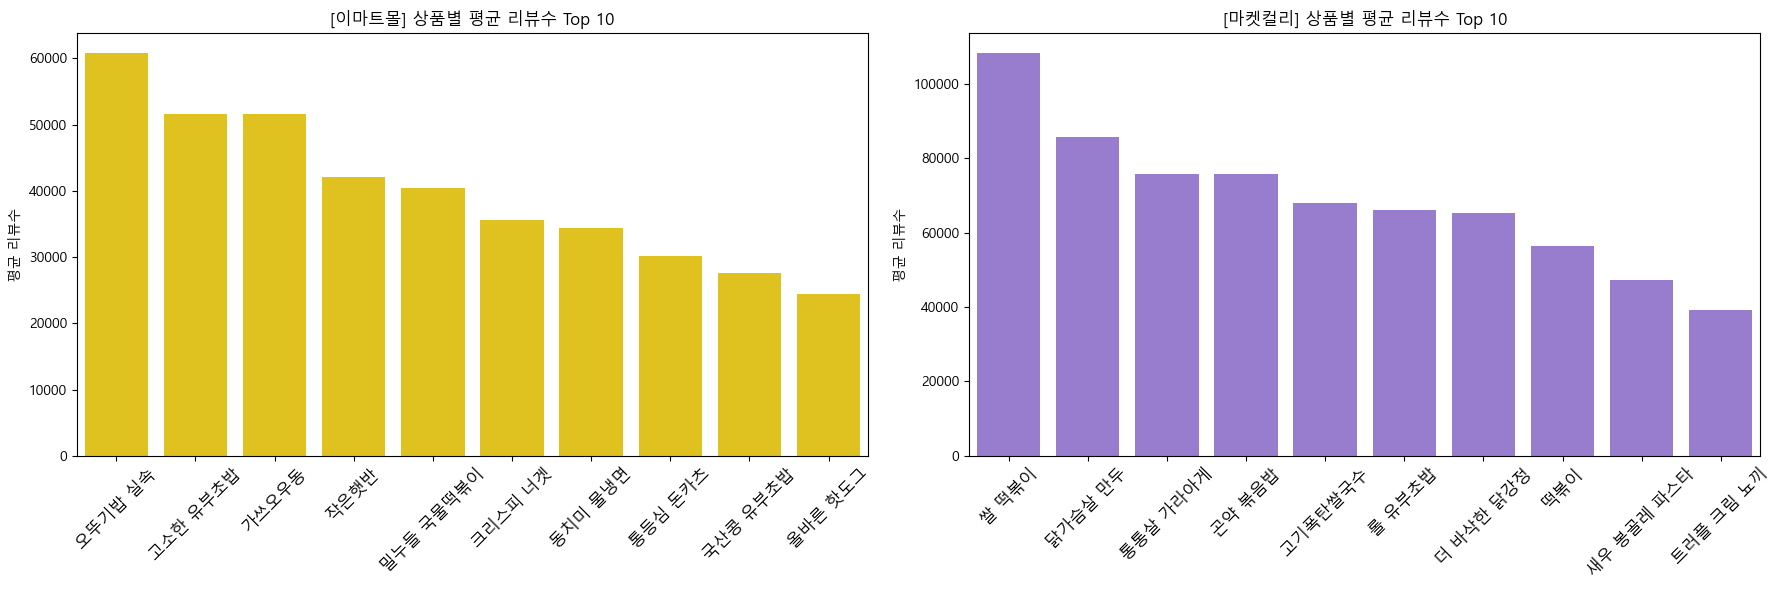

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 마켓컬리 Top 10 상품 (평균 리뷰수 기준)
top10_kurly = df_마켓컬리.groupby('상품명')['리뷰수'].mean().sort_values(ascending=False).head(10)

# 이마트몰 Top 10 상품 (평균 리뷰수 기준)
top10_emart = df_이마트몰.groupby('상품명')['리뷰수'].mean().sort_values(ascending=False).head(10)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 이마트몰 - 노란색
sns.barplot(x=top10_emart.index, y=top10_emart.values, ax=axes[0], color='#FFD700')
axes[0].set_title('[이마트몰] 상품별 평균 리뷰수 Top 10')
axes[0].set_xlabel('')  # 하단 '상품명' 제거
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].set_ylabel('평균 리뷰수')

# 마켓컬리 - 보라색
sns.barplot(x=top10_kurly.index, y=top10_kurly.values, ax=axes[1], color='#9370DB')
axes[1].set_title('[마켓컬리] 상품별 평균 리뷰수 Top 10')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].set_ylabel('평균 리뷰수')

plt.tight_layout()
plt.show()


C:\Users\ssuyeon2\AppData\Local\Temp\ipykernel_16132\4007917610.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=product_compare_melt, x='플랫폼', y='평균리뷰수', palette=['skyblue', 'orange'])


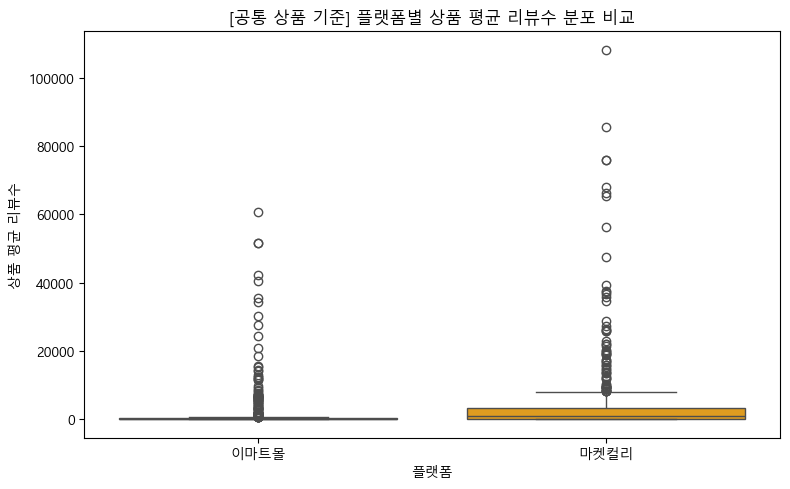

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 상품 기준 평균 리뷰수 집계
mean_emart = df_이마트몰.groupby('상품명')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '이마트몰'})
mean_kurly = df_마켓컬리.groupby('상품명')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '마켓컬리'})

# 병합 (공통 상품명만 추출됨)
product_compare = pd.merge(mean_emart, mean_kurly, on='상품명')

# melt for 시각화
product_compare_melt = product_compare.melt(id_vars='상품명', value_vars=['이마트몰', '마켓컬리'],
                                            var_name='플랫폼', value_name='평균리뷰수')

# 박스플롯 (분포 비교)
plt.figure(figsize=(8, 5))
sns.boxplot(data=product_compare_melt, x='플랫폼', y='평균리뷰수', palette=['skyblue', 'orange'])
plt.title('[공통 상품 기준] 플랫폼별 상품 평균 리뷰수 분포 비교')
plt.ylabel('상품 평균 리뷰수')
plt.tight_layout()
plt.show()


- 이마트몰은 오뚜기밥, 우유주스, 우동, 햇반 등 대형 브랜드 중심의 일반적인 식사대체형 상품이 리뷰 상위를 차지
- 마켓컬리는 쌀 떡볶이, 닭가슴살 만두, 관악 볶음밥, 동충하초, 더 바삭한 닭강정 등 가성비형 단품 간편식 또는 프리미엄 간편조리식이 상위권에 위치
- 마켓컬리의 상품별 평균 리뷰수는 전반적으로 이마트몰보다 월등히 높음 → 전체적으로 리뷰수를 늘리는 전략 필요

## 포장타입

In [21]:
df['포장타입'].value_counts()


포장타입
냉동    746
냉장    226
상온    214
Name: count, dtype: int64

In [22]:
df_이마트몰['포장타입'].value_counts()

포장타입
냉동    373
냉장    113
상온    107
Name: count, dtype: int64

C:\Users\ssuyeon2\AppData\Local\Temp\ipykernel_16132\1659806137.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=포장타입_분포, x='포장타입', y='상품 수', palette='Set2')


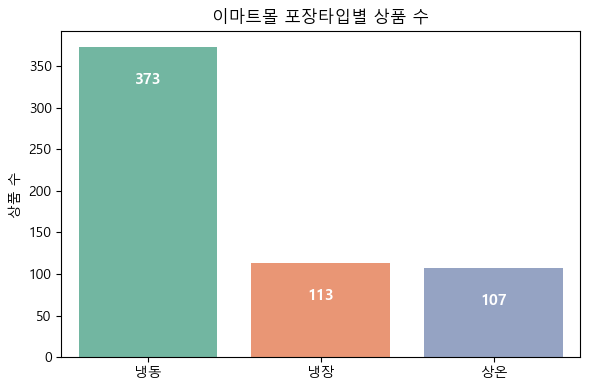

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 포장타입 분포
포장타입_분포 = df_이마트몰['포장타입'].value_counts().reset_index()
포장타입_분포.columns = ['포장타입', '상품 수']

# 시각화
plt.figure(figsize=(6, 4))
barplot = sns.barplot(data=포장타입_분포, x='포장타입', y='상품 수', palette='Set2')

# 막대 내부에 숫자 표시
for i, row in 포장타입_분포.iterrows():
    plt.text(i, row['상품 수'] - 30,  # 막대 안쪽으로 y값 조정
             f'{row["상품 수"]}', 
             ha='center', va='top', color='white', fontsize=11, fontweight='bold')

plt.title('이마트몰 포장타입별 상품 수')
plt.xlabel('')
plt.ylabel('상품 수')
plt.tight_layout()
plt.show()


In [24]:
df_마켓컬리['포장타입'].value_counts()

포장타입
냉동    373
냉장    113
상온    107
Name: count, dtype: int64

- 이마트몰, 마켓컬리 모두 냉동 -> 냉장 -> 상온 순이고 냉동 제품이 다수를 차지

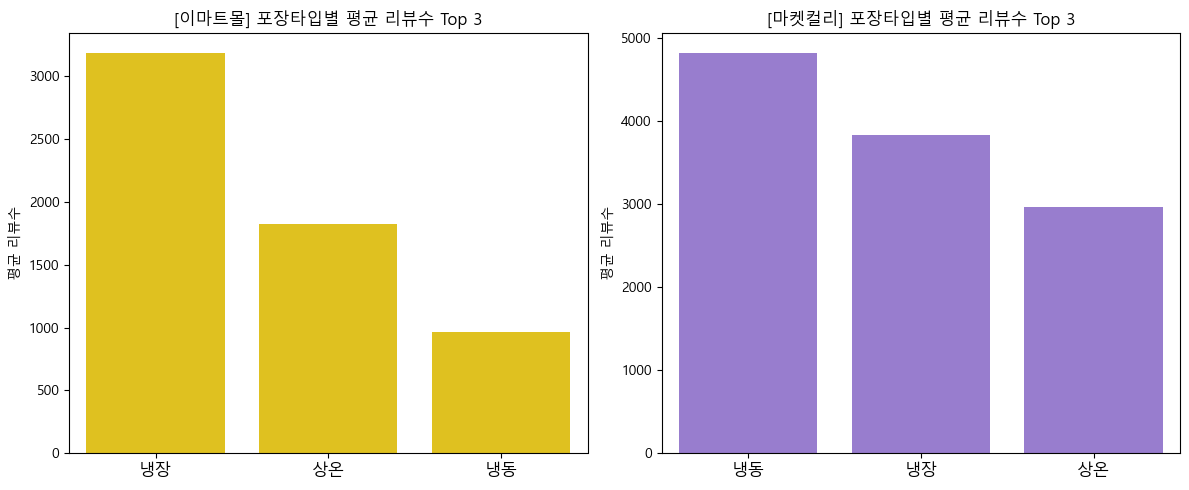

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 마켓컬리 포장타입별 평균 리뷰수
top3_kurly = df_마켓컬리.groupby('포장타입')['리뷰수'].mean().sort_values(ascending=False).head(3)

# 이마트몰 포장타입별 평균 리뷰수
top3_emart = df_이마트몰.groupby('포장타입')['리뷰수'].mean().sort_values(ascending=False).head(3)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 이마트몰 - 노란색
sns.barplot(x=top3_emart.index, y=top3_emart.values, ax=axes[0], color='#FFD700')
axes[0].set_title('[이마트몰] 포장타입별 평균 리뷰수 Top 3')
axes[0].set_ylabel('평균 리뷰수')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelsize=12)

# 마켓컬리 - 보라색
sns.barplot(x=top3_kurly.index, y=top3_kurly.values, ax=axes[1], color='#9370DB')
axes[1].set_title('[마켓컬리] 포장타입별 평균 리뷰수 Top 3')
axes[1].set_ylabel('평균 리뷰수')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()


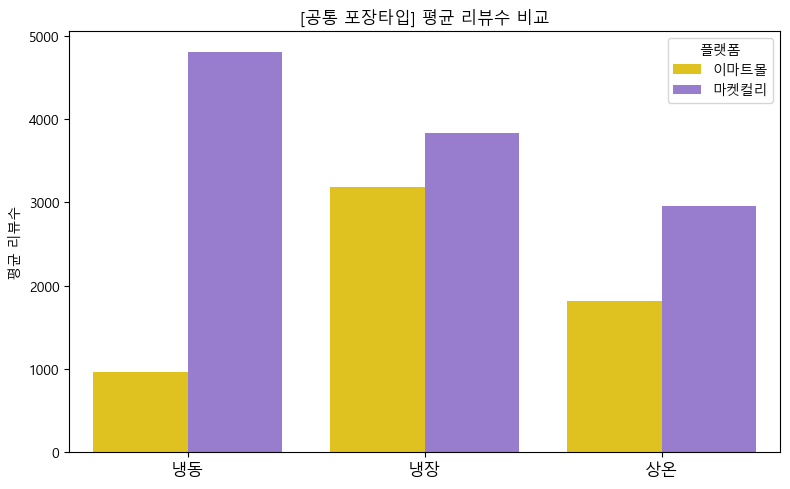

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 포장타입 기준 평균 리뷰수 집계
mean_emart = df_이마트몰.groupby('포장타입')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '이마트몰'})
mean_kurly = df_마켓컬리.groupby('포장타입')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '마켓컬리'})

# 병합
type_compare = pd.merge(mean_emart, mean_kurly, on='포장타입')

# 시각화 준비 (melt)
type_compare_melt = type_compare.melt(id_vars='포장타입', value_vars=['이마트몰', '마켓컬리'],
                                      var_name='플랫폼', value_name='평균리뷰수')

# 색상 매핑
palette = {'이마트몰': '#FFD700', '마켓컬리': '#9370DB'}

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=type_compare_melt, x='포장타입', y='평균리뷰수', hue='플랫폼', palette=palette)
plt.title('[공통 포장타입] 평균 리뷰수 비교')
plt.xlabel('')  # x축 레이블 제거
plt.ylabel('평균 리뷰수')
plt.xticks(fontsize=12)  # 포장타입 글자 크게
plt.tight_layout()
plt.show()


- 이마트몰은 냉장/상온 제품의 평균 리뷰수가 상대적으로 높아, 마켓컬리에 비해 오프라인 대체 장보기로 활용되는 성향이 강한 것으로 추정된다. 반면, 마켓컬리는 간편식의 핵심인 냉동 제품의 리뷰수가 가장 높아, 냉동 HMR 중심의 소비 경향이 뚜렷하게 나타난다.
- 하지만 이마트몰에서도 냉동 제품 수는 가장 많음에도 불구하고 리뷰수는 가장 낮아, 냉동 간편식에 대한 리뷰 유도 전략 강화가 필요한 상황

## 카테고리

In [27]:
df['카테고리'].value_counts()

카테고리
간편조리식품    306
분식        256
즉석식품      192
밀키트       175
곡물간편식     134
면류        101
샐러드간편식     22
Name: count, dtype: int64

In [28]:
df_이마트몰['카테고리'].value_counts()

카테고리
간편조리식품    153
분식        128
즉석식품       96
밀키트        88
곡물간편식      67
면류         50
샐러드간편식     11
Name: count, dtype: int64

In [29]:
df_마켓컬리['카테고리'].value_counts()

카테고리
간편조리식품    153
분식        128
즉석식품       96
밀키트        87
곡물간편식      67
면류         51
샐러드간편식     11
Name: count, dtype: int64

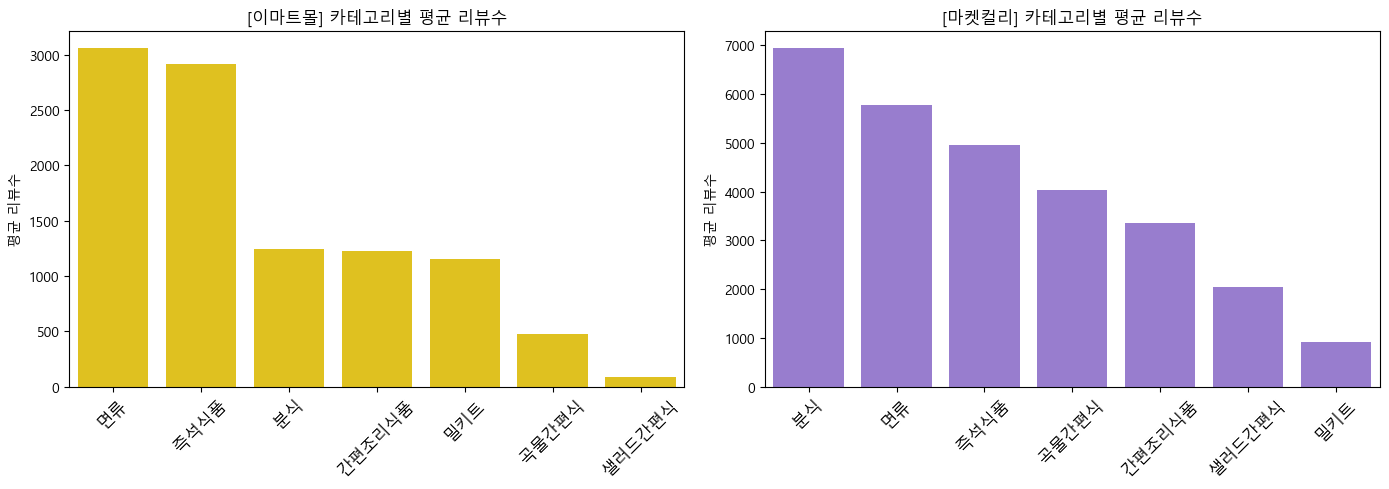

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 마켓컬리 카테고리별 평균 리뷰수
mean_kurly = df_마켓컬리.groupby('카테고리')['리뷰수'].mean().sort_values(ascending=False)

# 이마트몰 카테고리별 평균 리뷰수
mean_emart = df_이마트몰.groupby('카테고리')['리뷰수'].mean().sort_values(ascending=False)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 이마트몰 - 노란색
sns.barplot(x=mean_emart.index, y=mean_emart.values, ax=axes[0], color='#FFD700')
axes[0].set_title('[이마트몰] 카테고리별 평균 리뷰수')
axes[0].set_ylabel('평균 리뷰수')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45, labelsize=12)

# 마켓컬리 - 보라색
sns.barplot(x=mean_kurly.index, y=mean_kurly.values, ax=axes[1], color='#9370DB')
axes[1].set_title('[마켓컬리] 카테고리별 평균 리뷰수')
axes[1].set_ylabel('평균 리뷰수')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45, labelsize=12)

plt.tight_layout()
plt.show()


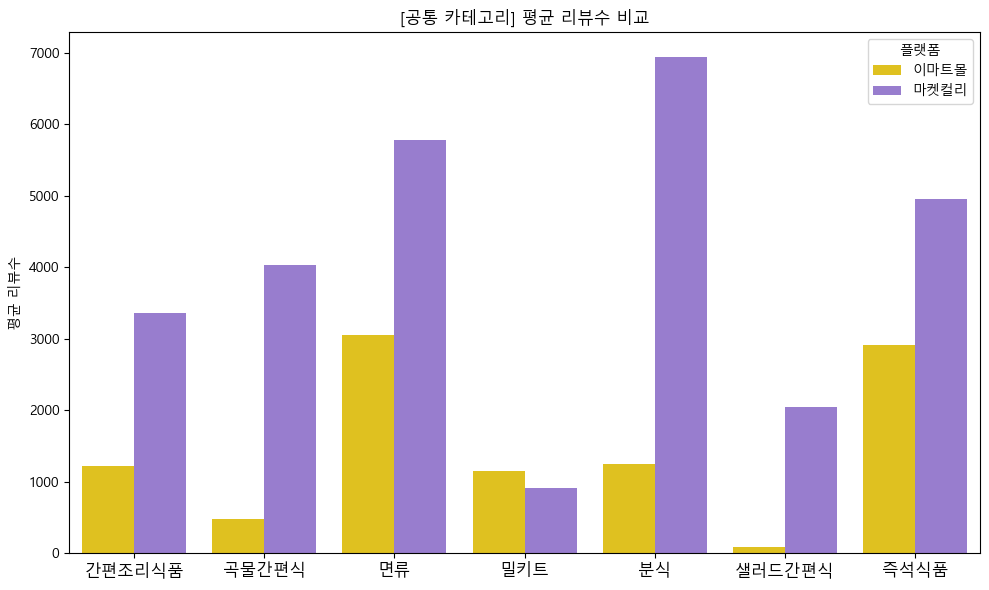

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 공통 카테고리 기준 평균 리뷰수 집계
mean_emart = df_이마트몰.groupby('카테고리')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '이마트몰'})
mean_kurly = df_마켓컬리.groupby('카테고리')['리뷰수'].mean().reset_index().rename(columns={'리뷰수': '마켓컬리'})

# 병합
category_compare = pd.merge(mean_emart, mean_kurly, on='카테고리')

# 시각화용 변환
category_compare_melt = category_compare.melt(
    id_vars='카테고리',
    value_vars=['이마트몰', '마켓컬리'],
    var_name='플랫폼',
    value_name='평균리뷰수'
)

# 색상 매핑
palette = {'이마트몰': '#FFD700', '마켓컬리': '#9370DB'}

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=category_compare_melt, x='카테고리', y='평균리뷰수', hue='플랫폼', palette=palette)
plt.title('[공통 카테고리] 평균 리뷰수 비교')
plt.xlabel('')
plt.ylabel('평균 리뷰수')
plt.xticks(rotation=0, fontsize=12)  # ✅ 카테고리 글자 일렬 정렬 + 크게
plt.tight_layout()
plt.show()


- 마켓컬리는 밀키트를 제외한 전 카테고리에서 평균 리뷰수가 이마트몰보다 확연히 높게 나타났으며, 특히 분식·샐러드·국물간편식 등에서의 격차는 매우 큼 -> 이 카테고리를 키우는 전략 필요

#  통계적 검증

1. 동일 상품 기준 플랫폼 간 값 차이 검정 (기준: 상품ID)
- 목적: 같은 상품의 마켓컬리 vs 이마트몰 수치값 차이가 유의한가?
- 대상 변수: 총용량, 입수량, 개당_가격, 10g당_가격, 할인율, 정상가, 판매가, 리뷰수, 긍정감성점수 

2. 연속형 변수 리뷰수와의 차이 검정
- 목적: 연속형 변수에 따라 리뷰수 차이가 있는가?
- 대상 변수: 총용량, 입수량, 개당_가격, 10g당_가격, 할인율, 정상가, 판매가, 긍정감성점수, 카테고리 검색량, 브랜드_검색량, 상품명_검색량
- 종속변수: 리뷰수

3. 범주형 변수 그룹별 반응 차이 검정
- 목적: 특정 속성(예: 포장타입, 카테고리 등)에 따라 리뷰수 차이가 있는가?
- 대상 변수: 사이트, 브랜드, 상품명, 포장타입, 카테고리
- 종속변수: 리뷰수

## 동일 상품 간 플랫폼 차이: 대응표본

- 상품ID 기준으로 마켓컬리 vs 이마트몰 값을 옆으로 붙인 데이터프레임을 만들어야 한다.

In [32]:
# 비교 대상 변수 목록
target_columns = [
    '총용량', '입수량', '개당_가격', '10g당_가격',
    '할인율', '정상가', '판매가', '리뷰수', '긍정감성점수'
]

# 각 사이트에서 비교할 변수만 추출
df_kurly = df_마켓컬리[['상품ID'] + target_columns].copy()
df_emart = df_이마트몰[['상품ID'] + target_columns].copy()

# 접미사 붙여서 구분
df_kurly = df_kurly.rename(columns={col: f"{col}_컬리" for col in target_columns})
df_emart = df_emart.rename(columns={col: f"{col}_이마트" for col in target_columns})

# 상품ID 기준 병합
df_상품비교 = pd.merge(df_kurly, df_emart, on='상품ID')


In [33]:
df_상품비교.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상품ID         593 non-null    object 
 1   총용량_컬리       593 non-null    int64  
 2   입수량_컬리       593 non-null    int64  
 3   개당_가격_컬리     593 non-null    int64  
 4   10g당_가격_컬리   593 non-null    int64  
 5   할인율_컬리       593 non-null    int64  
 6   정상가_컬리       593 non-null    int64  
 7   판매가_컬리       593 non-null    int64  
 8   리뷰수_컬리       593 non-null    int64  
 9   긍정감성점수_컬리    593 non-null    float64
 10  총용량_이마트      593 non-null    int64  
 11  입수량_이마트      593 non-null    int64  
 12  개당_가격_이마트    593 non-null    int64  
 13  10g당_가격_이마트  593 non-null    int64  
 14  할인율_이마트      593 non-null    int64  
 15  정상가_이마트      593 non-null    int64  
 16  판매가_이마트      593 non-null    int64  
 17  리뷰수_이마트      593 non-null    int64  
 18  긍정감성점수_이마트   593 non-null    float64
dtypes: float

In [34]:
# 동일 상품 기준 마켓컬리 vs 이마트몰 값 차이 통계검정 (상품ID 기준)

# 필요한 라이브러리 불러오기
from scipy.stats import shapiro, ttest_rel, wilcoxon
import pandas as pd

# 비교할 변수쌍 정의 (마켓컬리, 이마트몰 변수 이름)
변수쌍 = [
    ('총용량_컬리', '총용량_이마트'),
    ('입수량_컬리', '입수량_이마트'),
    ('개당_가격_컬리', '개당_가격_이마트'),
    ('10g당_가격_컬리', '10g당_가격_이마트'),
    ('할인율_컬리', '할인율_이마트'),
    ('정상가_컬리', '정상가_이마트'),
    ('판매가_컬리', '판매가_이마트'),
    ('리뷰수_컬리', '리뷰수_이마트'),
    ('긍정감성점수_컬리', '긍정감성점수_이마트')
]

# 결과 저장 리스트 초기화
결과 = []

# 각 변수쌍에 대해 반복 수행
for 컬리, 이마트 in 변수쌍:
    x = df_상품비교[컬리]
    y = df_상품비교[이마트]

    # [1] 정규성 검정 (Shapiro-Wilk)
    p_x = shapiro(x).pvalue
    p_y = shapiro(y).pvalue
    정규성 = p_x > 0.05 and p_y > 0.05

    # [2] 정규성에 따라 대응표본 검정 선택
    if 정규성:
        검정 = 'paired t-test'
        p_val = ttest_rel(x, y).pvalue
    else:
        검정 = 'Wilcoxon'
        p_val = wilcoxon(x, y).pvalue

    # [3] 결과 저장 (소수점 10자리까지 표시)
    결과.append({
        '변수': 컬리.replace('_컬리', ''),
        '정규성': '정규' if 정규성 else '비정규',
        '검정방법': 검정,
        'p-value': f'{p_val:.10f}',
        '유의함': '✅' if p_val < 0.05 else '❌'
    })

# [4] 결과 출력
df_검정결과 = pd.DataFrame(결과)
print(df_검정결과)



        변수  정규성      검정방법       p-value 유의함
0      총용량  비정규  Wilcoxon  0.0000000000   ✅
1      입수량  비정규  Wilcoxon  0.0048301434   ✅
2    개당_가격  비정규  Wilcoxon  0.0000000000   ✅
3  10g당_가격  비정규  Wilcoxon  0.0000000000   ✅
4      할인율  비정규  Wilcoxon  0.0000000000   ✅
5      정상가  비정규  Wilcoxon  0.0000000000   ✅
6      판매가  비정규  Wilcoxon  0.0000000000   ✅
7      리뷰수  비정규  Wilcoxon  0.0000000000   ✅
8   긍정감성점수  비정규  Wilcoxon  0.0000000000   ✅


- 모든 변수에서 p-value < 0.05 → 마켓컬리 vs 이마트몰 간 통계적으로 유의미한 차이 있음
- 검정방법은 모두 Wilcoxon signed-rank test → 두 집단 모두 정규성 X
- 입수량 변수의 p-value가 가장 높지만 여전히 유의함
- 두 플랫폼은 동일 상품을 판매하더라도 제품 구성(용량/입수량), 가격 전략(정상가/할인율), 리뷰 및 감성 반응 등 모든 측면에서 구조적으로 다르다

## 연속형 변수에 따라 리뷰수 차이

- 리뷰수에 영향을 줄 수 있는 수치형 변수들에 대해,
마켓컬리와 이마트몰 각각에서 상관관계를 분석하고 차이를 비교
→ 어떤 변수에서 두 플랫폼 간 리뷰수와의 관계 방향·강도 차이가 있는지를 파악

### 정규성 검정: Shapiro-Wilk 검정

- 상관관계 분석 전에 정규성 검정하여 모수 검정(피어슨) vs 비모수 검정(스피어만) 중 선택

In [35]:
from scipy.stats import shapiro

# ▶ 프레임 이름별로 정규성 검정
frames = {
    '전체': df,
    '이마트몰': df_이마트몰,
    '마켓컬리': df_마켓컬리
}

cont_vars = [
    '총용량', '입수량', '개당_가격', '10g당_가격', '할인율',
    '정상가', '판매가', '긍정감성점수',
    '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수'
]

for name, frame in frames.items():
    print(f"\n\n===== ✅ {name} 프레임 정규성 검정 결과 =====")
    for var in cont_vars:
        try:
            stat, p = shapiro(frame[var].dropna())
            print(f"{var}: p-value = {p:.4f} → {'정규성 만족' if p > 0.05 else '정규성 불만족'}")
        except Exception as e:
            print(f"{var}: ⚠️ 오류 발생: {e}")




===== ✅ 전체 프레임 정규성 검정 결과 =====
총용량: p-value = 0.0000 → 정규성 불만족
입수량: p-value = 0.0000 → 정규성 불만족
개당_가격: p-value = 0.0000 → 정규성 불만족
10g당_가격: p-value = 0.0000 → 정규성 불만족
할인율: p-value = 0.0000 → 정규성 불만족
정상가: p-value = 0.0000 → 정규성 불만족
판매가: p-value = 0.0000 → 정규성 불만족
긍정감성점수: p-value = 0.0000 → 정규성 불만족
카테고리_검색량: p-value = 0.0000 → 정규성 불만족
브랜드_검색량: p-value = 0.0000 → 정규성 불만족
상품명_검색량: p-value = 0.0000 → 정규성 불만족
리뷰수: p-value = 0.0000 → 정규성 불만족


===== ✅ 이마트몰 프레임 정규성 검정 결과 =====
총용량: p-value = 0.0000 → 정규성 불만족
입수량: p-value = 0.0000 → 정규성 불만족
개당_가격: p-value = 0.0000 → 정규성 불만족
10g당_가격: p-value = 0.0000 → 정규성 불만족
할인율: p-value = 0.0000 → 정규성 불만족
정상가: p-value = 0.0000 → 정규성 불만족
판매가: p-value = 0.0000 → 정규성 불만족
긍정감성점수: p-value = 0.0000 → 정규성 불만족
카테고리_검색량: p-value = 0.0000 → 정규성 불만족
브랜드_검색량: p-value = 0.0000 → 정규성 불만족
상품명_검색량: p-value = 0.0000 → 정규성 불만족
리뷰수: p-value = 0.0000 → 정규성 불만족


===== ✅ 마켓컬리 프레임 정규성 검정 결과 =====
총용량: p-value = 0.0000 → 정규성 불만족
입수량: p-value = 0.0000 → 정규성 불만족
개당_가격: p-value = 0.00

- Shapiro-Wilk 검정 결과,
이마트몰과 마켓컬리의 수치형 변수들은 모두 정규성을 만족하지 않음 (p-value < 0.05).
→ 따라서 모수 검정(피어슨 상관계수)은 부적절하며,
→ **비모수 검정(스피어만 상관계수, Spearman’s ρ)**를 사용해 상관관계 분석을 진행함.

### 비모수 검정: Spearman 상관계수

In [36]:
import pandas as pd

# ✅ 모든 행 출력 설정 (결과 확인용)
pd.set_option('display.max_rows', None)

# ✅ 1️⃣ 상관관계 분석 대상 수치형 변수 지정
columns = [
    '리뷰수', '개당_가격', '10g당_가격', '총용량', '입수량',
    '할인율', '정상가', '판매가', '긍정감성점수',
    '카테고리_검색량', '브랜드_검색량', '상품명_검색량'
]

# ✅ 2️⃣ 이마트몰, 마켓컬리 각각 스피어만 상관계수 계산 (리뷰수 기준)
corr_emart = df_이마트몰[columns].corr(method='spearman')['리뷰수']
corr_kurly = df_마켓컬리[columns].corr(method='spearman')['리뷰수']

# ✅ 3️⃣ 비교용 데이터프레임 생성 (차이 계산 및 정렬)
corr_compare = pd.DataFrame({
    '이마트몰': corr_emart,
    '마켓컬리': corr_kurly,
    '차이': corr_kurly - corr_emart
}).sort_values(by='차이', ascending=False)

# ✅ 4️⃣ 출력
display(corr_compare)


,이마트몰,마켓컬리,차이
판매가,-0.451677,-0.088238,0.363439
정상가,-0.450894,-0.130412,0.320482
입수량,-0.265657,0.037010,0.302667
10g당_가격,-0.312145,-0.034792,0.277354
총용량,-0.147044,-0.035617,0.111427
개당_가격,-0.163429,-0.087552,0.075878
리뷰수,1.000000,1.000000,0.000000
할인율,-0.045109,-0.087853,-0.042743
상품명_검색량,0.310240,0.130180,-0.180060
카테고리_검색량,0.023342,-0.196485,-0.219827


[이마트몰 전략]
1. 가격 관련 분석
- 이마트몰은 리뷰 수와 가격 간의 음의 상관관계가 마켓컬리보다 강하게 나타났으며, 이는 가격이 높을수록 리뷰 수가 감소하는 경향이 더 뚜렷함을 의미. → 이마트몰 고객은 가격에 더 민감하게 반응하는 구조로 해석 -> 고가 제품에 대한 품질 신뢰 확보
2. 검색량 관련 분석
- 이마트몰에서는 브랜드, 카테고리, 상품명 검색량과 리뷰수 간의 상관관계가 마켓컬리보다 높게 나타나,
검색 노출이나 인지도가 리뷰 유입에 미치는 영향이 더 큰 플랫폼
→ 즉, 인지도가 낮은 제품이라 하더라도 검색 노출·콘텐츠 강화 등을 통해 리뷰 유입을 유도할 여지가 크므로 활성화 전략이 필요

### 비모수 검정: 히트맵(나눠서 분석)

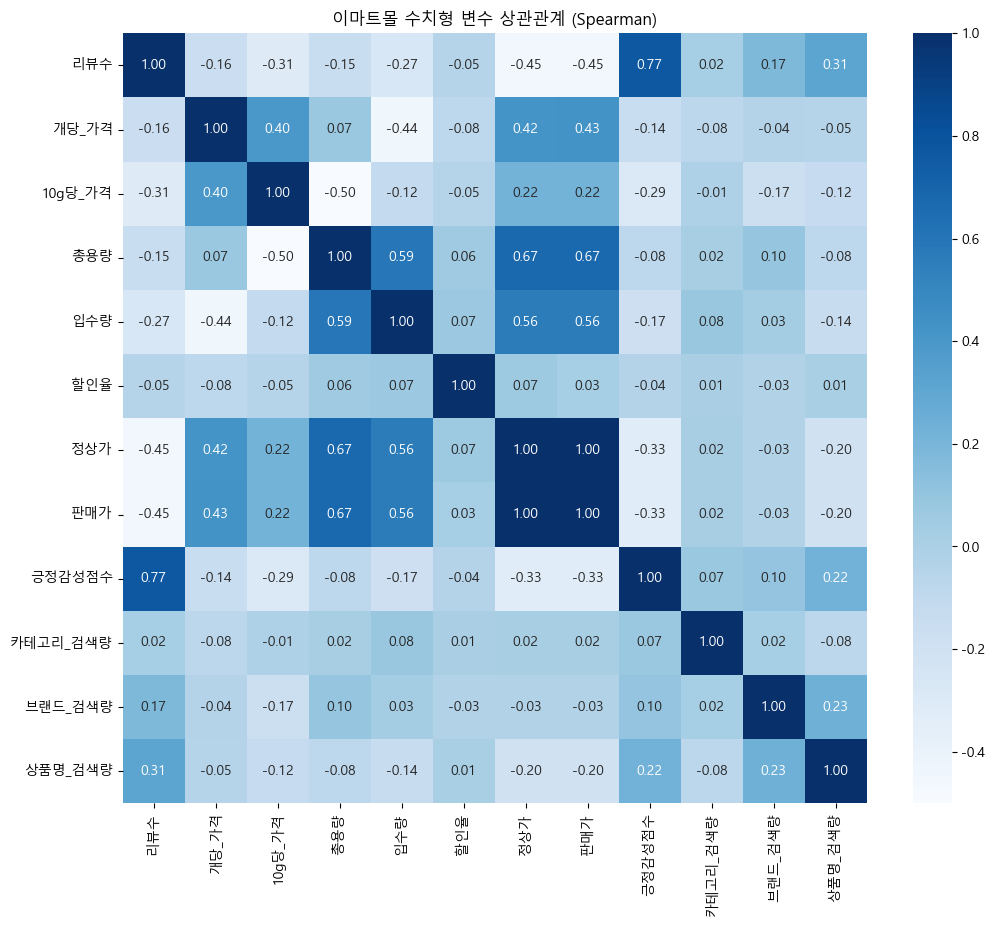

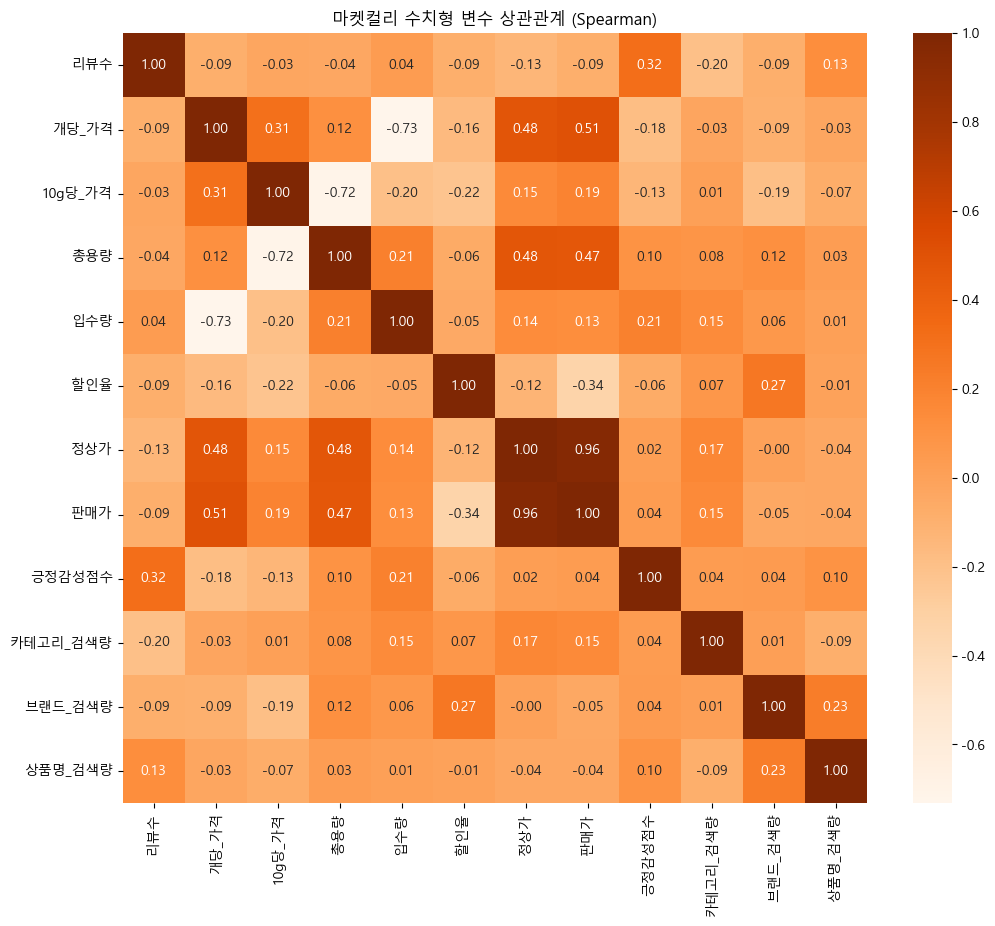

In [37]:
import seaborn as sns
# 이마트몰 히트맵 (비모수 상관계수)
plt.figure(figsize=(12, 10))
sns.heatmap(df_이마트몰[columns].corr(method='spearman'), annot=True, fmt=".2f", cmap='Blues')
plt.title("이마트몰 수치형 변수 상관관계 (Spearman)")
plt.show()

# 마켓컬리 히트맵 (비모수 상관계수)
plt.figure(figsize=(12, 10))
sns.heatmap(df_마켓컬리[columns].corr(method='spearman'), annot=True, fmt=".2f", cmap='Oranges')
plt.title("마켓컬리 수치형 변수 상관관계 (Spearman)")
plt.show()

1. 가격관련 변수 vs 리뷰수
- 이마트몰은 가격 민감도 더 큼 → 고가 간편식은 "품질 보장 강조 콘텐츠"로 대응 필요
2. 검색량 변수 vs 리뷰수
- 이마트몰은 검색량과 더 높은 연관 -> 인기 상품명/브랜드 위주로 노출 강화로 인지도 더 활용하거나 마켓컬리 처럼 제품 단위 중심 전략 사용하기
3. 긍정감성점수 vs 리뷰수
- 이마트몰은 리뷰의 긍정도가 높을수록 리뷰도 많음 → 만족도 높은 제품 위주로 리뷰 노출/후기 공유 이벤트 강화

### 비모수 검정: 히트맵(나란히 분석)

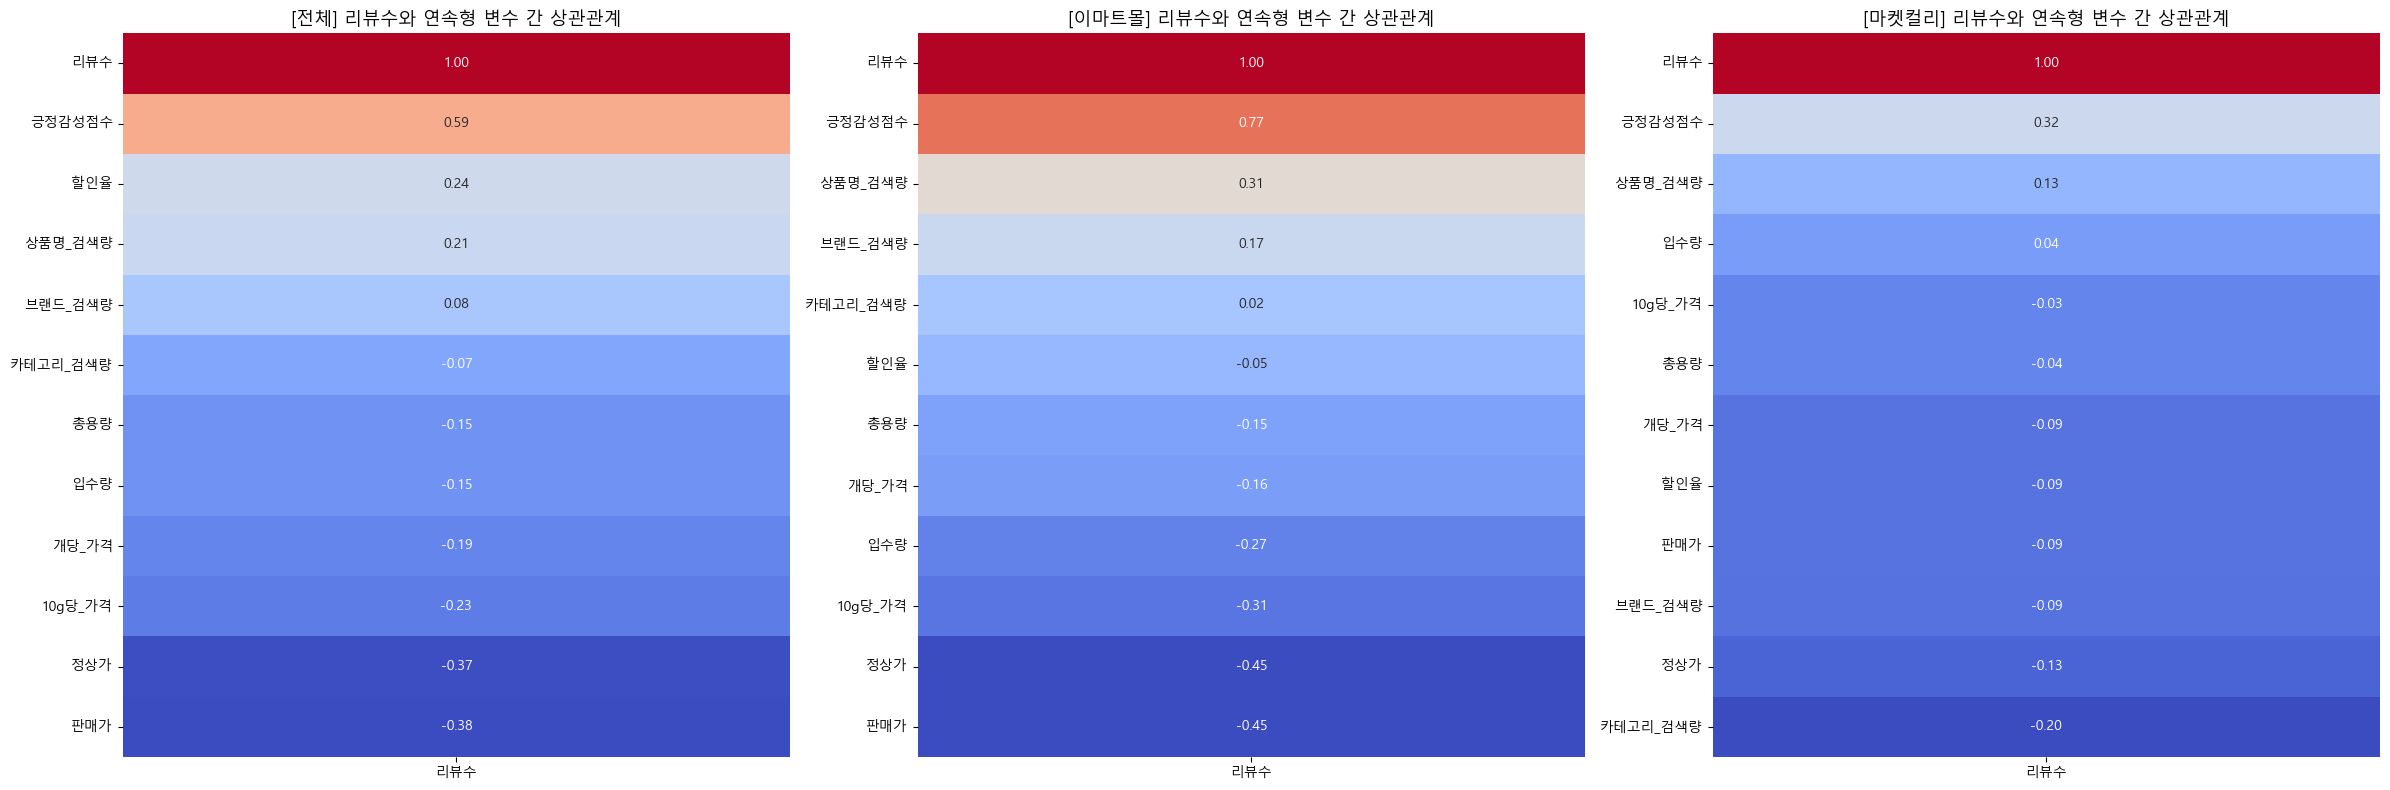

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# ▶ 분석할 데이터프레임들을 딕셔너리로 정리
frames = {
    '전체': df,
    '이마트몰': df_이마트몰,
    '마켓컬리': df_마켓컬리
}

# ▶ 연속형 변수 목록 (리뷰수 포함)
cont_vars = [
    '총용량', '입수량', '개당_가격', '10g당_가격', '할인율',
    '정상가', '판매가', '긍정감성점수',
    '카테고리_검색량', '브랜드_검색량', '상품명_검색량', '리뷰수'
]

# ▶ subplot 설정 (3개 가로 배치)
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # 가로 3개, 전체 크기 조정

# ▶ 각 프레임에 대해 히트맵 그리기
for ax, (name, frame) in zip(axes, frames.items()):
    corr = frame[cont_vars].corr(method='spearman')
    sns.heatmap(
        corr[['리뷰수']].sort_values(by='리뷰수', ascending=False),
        annot=True, fmt=".2f", cmap='coolwarm', cbar=False, ax=ax
    )
    ax.set_title(f"[{name}] 리뷰수와 연속형 변수 간 상관관계", fontsize=13)

plt.tight_layout()
plt.show()


1. 전체 데이터 기준
- 긍정감성점수와의 상관계수 ρ = 0.59 → 긍정 리뷰가 많은 상품일수록 리뷰 수도 많음
- 할인율(ρ = 0.24), 상품명_검색량(ρ = 0.21) → 노출 및 프로모션이 리뷰 유도에 일정 효과 있음
- 가격 관련 변수(정상가 -0.37, 판매가 -0.38) → 가격이 높을수록 리뷰수는 낮아지는 경향 → 가격 민감도 있는 제품이 더 많이 리뷰됨

2. 이마트몰 기준 
- 긍정감성점수와 리뷰수 ρ = 0.77 (가장 강한 상관) → 리뷰가 많은 상품은 높은 만족도를 동반
- 상품명_검색량(ρ = 0.31), 브랜드_검색량(ρ = 0.17) → 인지도 있는 브랜드가 리뷰도 많이 확보
- 정상가, 판매가 각각 -0.45 → 가격이 높은 상품은 리뷰가 현저히 적음 → 이마트몰은 리뷰 수가 가격과 반비례 관계

3. 마켓컬리 기준
- 대부분 변수와의 상관계수 |ρ| < 0.10 수준 (매우 약함)
- 긍정감성점수(ρ = 0.32)만 일정 부분 양의 상관
- 가격, 검색량, 용량 등의 변수는 거의 영향 없음
→ 마켓컬리는 리뷰 수에 영향을 주는 명확한 연속형 변수가 없음
→ 플랫폼 자체의 브랜딩, UX, 리뷰 유도 구조 등의 비정량 요인 영향 추정

### 연속형 변수 전체 로그변환 후 히트맵

- 리뷰수에 영향을 줄 수 있는 수치형 변수들에 대해,
마켓컬리와 이마트몰 각각에서 상관관계를 분석하고 차이를 비교
→ 어떤 변수에서 두 플랫폼 간 리뷰수와의 관계 방향·강도 차이가 있는지를 파악

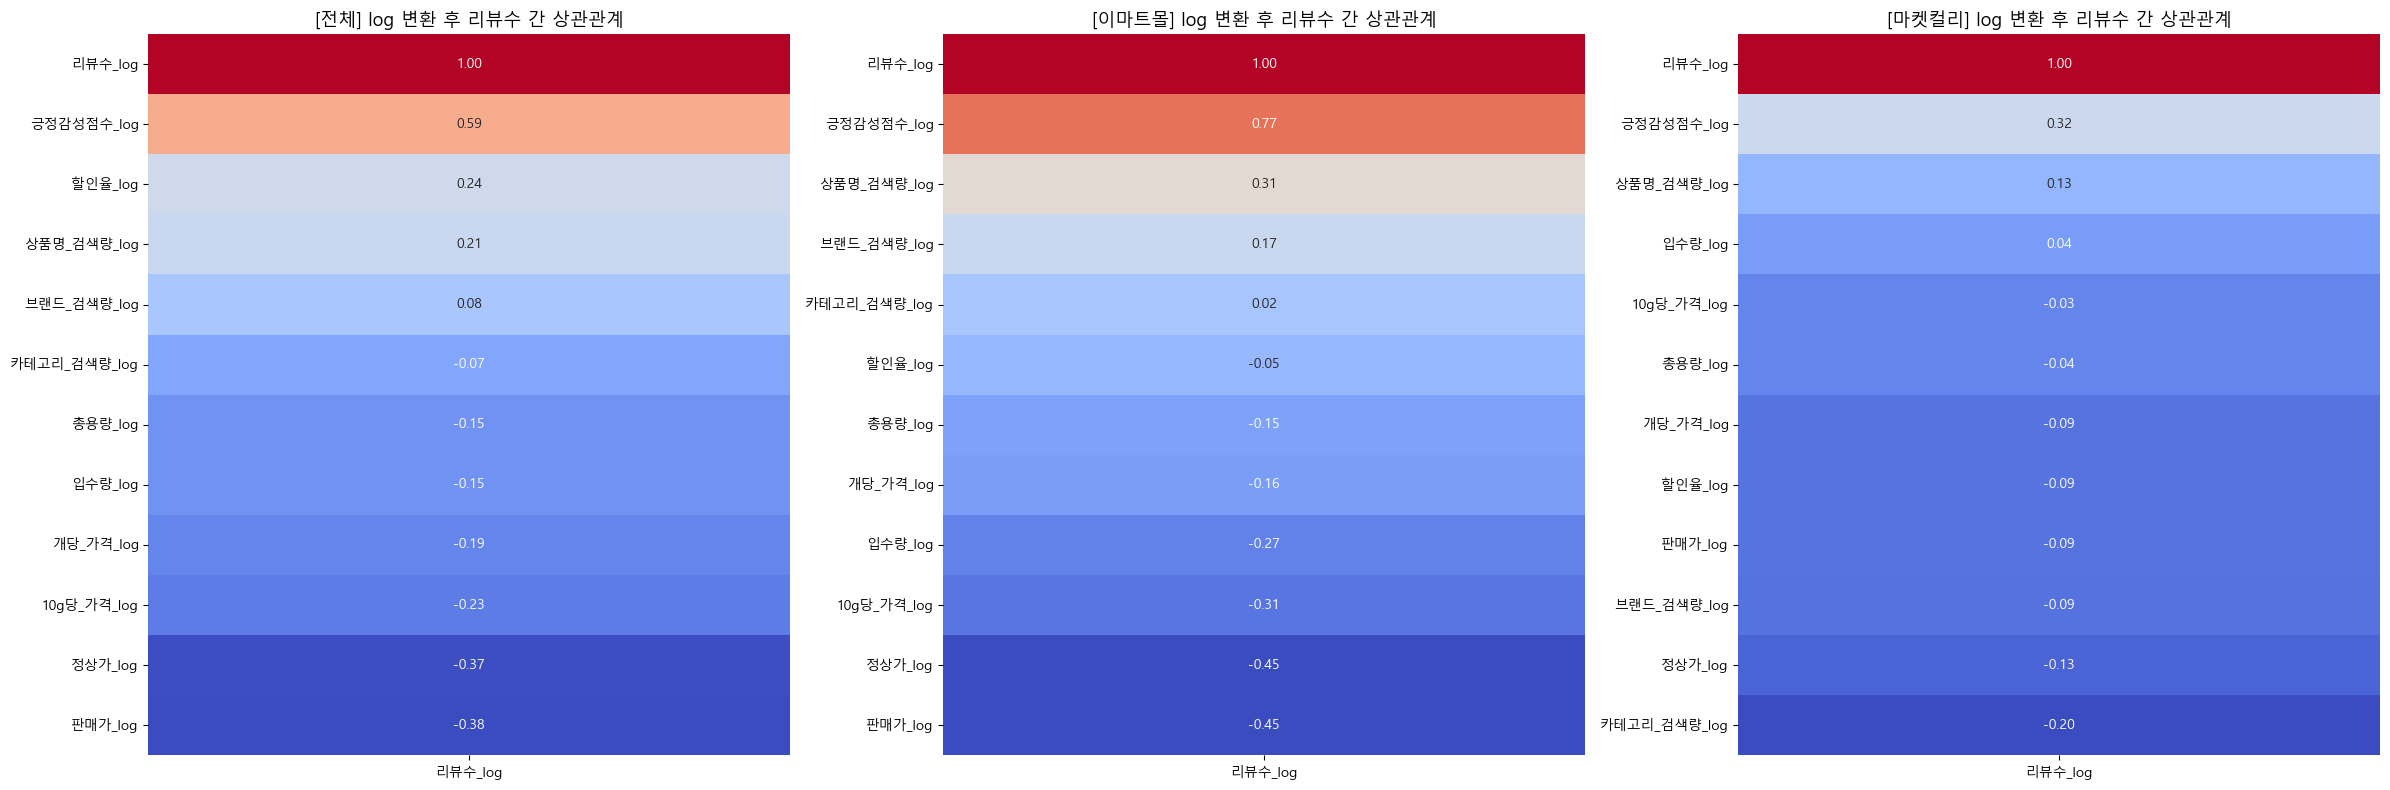

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ▶ 일렬 히트맵 출력 함수 (log 변환된 변수)
def draw_log_heatmap_side_by_side(dataframes, cont_vars):
    # ▶ subplot 구성 (3개 가로)
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for ax, (name, frame) in zip(axes, dataframes.items()):
        df_temp = frame.copy()

        # ▶ 전체 연속형 변수 log1p 변환
        for col in cont_vars:
            df_temp[col + '_log'] = np.log1p(df_temp[col])

        log_cols = [col + '_log' for col in cont_vars]
        corr = df_temp[log_cols].corr(method='spearman')

        # ▶ 리뷰수_log와 나머지 간 관계만 시각화
        sns.heatmap(
            corr[['리뷰수_log']].sort_values(by='리뷰수_log', ascending=False),
            annot=True, fmt=".2f", cmap='coolwarm', cbar=False, ax=ax
        )
        ax.set_title(f"[{name}] log 변환 후 리뷰수 간 상관관계", fontsize=13)

    plt.tight_layout()
    plt.show()

# ▶ 사용 예시
draw_log_heatmap_side_by_side(frames, cont_vars)


- 전체적으로 상관계수 값 크게 변하지 않음 -> 로그 변환 안한 걸로 분석하기

## 범주형 그룹별 리뷰수 차이

- 대상 변수: 사이트, 브랜드, 상품명, 포장타입, 카테고리
- 종속변수: 리뷰수
- 앞서 Shapiro-Wilk 검정 결과, 리뷰수를 포함한 모든 연속형 변수에서 정규성이 만족되지 않았음.
- 따라서, t-test나 ANOVA 대신 비모수 검정(Mann-Whitney, Kruskal-Wallis)을 사용함.
- 그룹이 2개밖에 없는 사이트는 Mann-Whitney 사용 -> df 프레임만 사용
- 나머지 브랜드, 상품명, 포장타입, 카테고리는 Kruskal-Wallis 사용 -> df, df_이마트몰, df_마켓컬리 비교 분석

### 1. 사이트 (2그룹 → Mann-Whitney U Test)

In [40]:
from scipy.stats import mannwhitneyu

# 사이트에 따른 리뷰수 차이 (이마트몰 vs 마켓컬리)
group1 = df_이마트몰['리뷰수']
group2 = df_마켓컬리['리뷰수']

stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
print(f"[사이트] Mann-Whitney U Test: statistic = {stat:.3f}, p-value = {p:.5f}")


[사이트] Mann-Whitney U Test: statistic = 70800.500, p-value = 0.00000


- 귀무가설: "이마트몰과 마켓컬리의 리뷰수 분포에는 차이가 없다."
- p-value < 0.05이므로 귀무가설을 기각함
- 이마트몰과 마켓컬리 간 리뷰수 분포는 통계적으로 유의하게 다르다.
- 즉, 동일 상품이라 하더라도 마켓컬리 쪽 리뷰 수가 더 활발할 가능성을 시사

### 2. 브랜드 (Kruskal-Wallis 검정 코드)

In [41]:
from scipy.stats import kruskal

# ▶ 분석할 프레임들 (전체, 이마트몰, 마켓컬리)
frames = {
    '전체': df,
    '이마트몰': df_이마트몰,
    '마켓컬리': df_마켓컬리
}

# ▶ 검정 결과 저장
for name, frame in frames.items():
    # 브랜드별 리뷰수 리스트 생성
    groups = [group['리뷰수'].values for _, group in frame.groupby('브랜드') if len(group) >= 2]  # 2개 이상인 그룹만

    # Kruskal-Wallis 검정 수행
    stat, p = kruskal(*groups)
    print(f"[브랜드 - {name}] Kruskal-Wallis H Test: statistic = {stat:.3f}, p-value = {p:.5f}")


[브랜드 - 전체] Kruskal-Wallis H Test: statistic = 199.737, p-value = 0.00296
[브랜드 - 이마트몰] Kruskal-Wallis H Test: statistic = 162.486, p-value = 0.00000
[브랜드 - 마켓컬리] Kruskal-Wallis H Test: statistic = 204.094, p-value = 0.00000


- 귀무가설: 브랜드 간 리뷰 수의 분포는 동일하다.
- p-value < 0.05 → 귀무가설 기각
- 브랜드에 따라 리뷰 수 분포가 통계적으로 유의미하게 다름
- 이는 특정 브랜드의 리뷰가 특히 많거나 적다는 것을 의미할 수 있음 → 브랜드별 리뷰 집중도 존재

### 2. 상품명 (Kruskal-Wallis 검정 코드)

In [42]:
from scipy.stats import kruskal

# ▶ 분석할 프레임들 (전체, 이마트몰, 마켓컬리)
frames = {
    '전체': df,
    '이마트몰': df_이마트몰,
    '마켓컬리': df_마켓컬리
}

# ▶ 검정 결과 저장
for name, frame in frames.items():
    # 브랜드별 리뷰수 리스트 생성
    groups = [group['리뷰수'].values for _, group in frame.groupby('상품명') if len(group) >= 2]  # 2개 이상인 그룹만

    # Kruskal-Wallis 검정 수행
    stat, p = kruskal(*groups)
    print(f"[상품명 - {name}] Kruskal-Wallis H Test: statistic = {stat:.3f}, p-value = {p:.5f}")

[상품명 - 전체] Kruskal-Wallis H Test: statistic = 478.444, p-value = 0.99838
[상품명 - 이마트몰] Kruskal-Wallis H Test: statistic = 7.622, p-value = 0.90808
[상품명 - 마켓컬리] Kruskal-Wallis H Test: statistic = 15.356, p-value = 0.35426


- 귀무가설 (H₀): 상품명 간 리뷰 수의 분포는 동일하다
- 상품명 간 리뷰 수의 분포에는 통계적으로 유의미한 차이가 없음
- 상품 개별 이름보다는 브랜드, 가격, 포장 방식 등 다른 속성이 리뷰 수에 더 큰 영향을 줄 수 있음을 시사

### 3. 포장타입 (Kruskal-Wallis 검정 코드)

In [43]:
from scipy.stats import kruskal

# ▶ 분석할 프레임들 (전체, 이마트몰, 마켓컬리)
frames = {
    '전체': df,
    '이마트몰': df_이마트몰,
    '마켓컬리': df_마켓컬리
}

# ▶ 검정 결과 저장
for name, frame in frames.items():
    # 브랜드별 리뷰수 리스트 생성
    groups = [group['리뷰수'].values for _, group in frame.groupby('포장타입') if len(group) >= 2]  # 2개 이상인 그룹만

    # Kruskal-Wallis 검정 수행
    stat, p = kruskal(*groups)
    print(f"[포장타입 - {name}] Kruskal-Wallis H Test: statistic = {stat:.3f}, p-value = {p:.5f}")

[포장타입 - 전체] Kruskal-Wallis H Test: statistic = 13.887, p-value = 0.00096
[포장타입 - 이마트몰] Kruskal-Wallis H Test: statistic = 25.793, p-value = 0.00000
[포장타입 - 마켓컬리] Kruskal-Wallis H Test: statistic = 2.828, p-value = 0.24312


- 포장타입(냉동, 냉장, 상온 등)에 따라 리뷰 수 분포는 동일하다.
- 전체 데이터에서 p-value < 0.05 → 귀무가설 기각
- 이마트몰도 p-value < 0.05 → 귀무가설 기각 -> 이마트몰에서는 포장타입이 리뷰 수에 영향을 미친다
- 반면 마켓컬리는 p-value > 0.05 → 마켓컬리에서는 포장타입에 따른 리뷰 수 차이가 통계적으로 유의하지 않다.



### 4. 카테고리 (Kruskal-Wallis 검정 코드)

In [44]:
from scipy.stats import kruskal

# ▶ 분석할 프레임들 (전체, 이마트몰, 마켓컬리)
frames = {
    '전체': df,
    '이마트몰': df_이마트몰,
    '마켓컬리': df_마켓컬리
}

# ▶ 검정 결과 저장
for name, frame in frames.items():
    # 브랜드별 리뷰수 리스트 생성
    groups = [group['리뷰수'].values for _, group in frame.groupby('카테고리') if len(group) >= 2]  # 2개 이상인 그룹만

    # Kruskal-Wallis 검정 수행
    stat, p = kruskal(*groups)
    print(f"[카테고리 - {name}] Kruskal-Wallis H Test: statistic = {stat:.3f}, p-value = {p:.5f}")

[카테고리 - 전체] Kruskal-Wallis H Test: statistic = 35.682, p-value = 0.00000
[카테고리 - 이마트몰] Kruskal-Wallis H Test: statistic = 18.900, p-value = 0.00434
[카테고리 - 마켓컬리] Kruskal-Wallis H Test: statistic = 67.720, p-value = 0.00000


- 귀무가설: 카테고리 간 리뷰 수 분포는 동일하다.
- 모두 p-value = 0.00000 < 0.05 → 귀무가설 기각 -> 카테고리에 따라 리뷰 수 분포는 통계적으로 유의하게 다름